The Sydney AirBnB dataset consists of multiple categories of data. The data has been divided into three different categories:
\begin{enumerate}
    \item Reviews
    \item Listings
    \item Calendar Entries
\end{enumerate}

In particular, the most valuable and meaningful data are the reviews and listings data. The data that is being used was last updated on 16th March, 2020 and can be found [here](http://insideairbnb.com/get-the-data.html). In our EDA, we wish to understand which factors in the data influence demand. The goal is to visualise the rental landscape and try to understand the aspects influencing the demand.

The majority of this analysis is influenced by the work performed on the Berlin AirBnB dataset, which can also be found [here](https://www.kaggle.com/brittabettendorf/what-factors-influence-demand-eda-occupancy). However, additional analysis is also included with the contribution of my domain knowledge about Sydney and Sydney suburbs.

## Import relevant libraries for EDA

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
import folium

import warnings
warnings.filterwarnings("ignore")

## Obtaining and viewing the data

In [3]:
df_raw = pd.read_csv('../data/reviews.csv')
df_raw.tail(2)

,listing_id,id,date,reviewer_id,reviewer_name,comments
642496,42866148,618202383,2020-03-14,76606411,Mathys,"Good bedroom, good comfort !"
642497,42881748,618201416,2020-03-14,135429487,Jeff,"Place is great, clean and convenient"


In [4]:
# drop unnecessary columns
df_raw.drop(['reviewer_id', 'reviewer_name', 'comments'], axis=1, inplace=True)

# rename the id and set to 1 to later calculate the total number of reviews per listing per month
df_raw.rename({'id':'review_count'}, axis=1, inplace=True)
df_raw.review_count=1

# checking shape and duplicates
print("The first dataset has {} rows and {} columns.".format(*df_raw.shape))
print("It contains {} duplicates.".format(df_raw.duplicated().sum()))

df_raw.head(2)

The first dataset has 642498 rows and 3 columns.
It contains 8358 duplicates.


,listing_id,review_count,date
0,11156,1,2009-12-05
1,11156,1,2010-03-31


## Preprocessing the data

### Engineering reviews per month

In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 642498 entries, 0 to 642497
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   listing_id    642498 non-null  int64 
 1   review_count  642498 non-null  int64 
 2   date          642498 non-null  object
dtypes: int64(2), object(1)
memory usage: 14.7+ MB


In [6]:
# cast date-column from current object datatype to datetime datatype

df_raw.date = pd.to_datetime(df_raw.date, format="%Y-%m-%d")

Let's take a year's worth of data from the dataset. The most recent 12 months of data will be considered for analysis. In addition to those constraints, it is worth noting that Australia, and in particular NSW, has been facing global crises such as the Australian bush fires and the Novel COVID-19. These crises have definitely impacted the rental market, and as such, 12 months of data prior to November, 2019 will be considered. As such, we will have a full year starting November 1st, 2018 and ending October 31st, 2019.

In [7]:
count_2018_2019 = df_raw[df_raw["date"].isin(pd.date_range('2018-11-01', '2019-10-31'))]
print("The dataset 2017/2018 has {} reviews and {} columns.".format(*count_2018_2019.shape))


The dataset 2017/2018 has 217437 reviews and 3 columns.


In [8]:
# set the date as index and sort by index
count_2018_2019 = count_2018_2019.set_index('date').sort_index()

Calculate reviews per month.

In [9]:
# agg argument: #work on this col:  {#name the new col : #perform count operation}                        
count_2018_2019_monthly = ( count_2018_2019.groupby([pd.Grouper(freq='M'), 'listing_id'])
                            .agg({'review_count':'count'})
                            .rename(columns={'review_count':'reviews_per_month'})
                            .reset_index() )


In [10]:
count_2018_2019_monthly.head(5)

,date,listing_id,reviews_per_month
0,2018-11-30,11156,2
1,2018-11-30,12351,4
2,2018-11-30,15253,5
3,2018-11-30,44545,1
4,2018-11-30,58506,3


In [11]:
# group by listing_id and count reviews and calculate average number of reviews in 12 months
count_2018_2019_monthly = ( count_2018_2019_monthly.groupby(['listing_id'])
                           .agg({'reviews_per_month':'mean'})
                           .reset_index() )

In [12]:
count_2018_2019_monthly.head(5)

,listing_id,reviews_per_month
0,11156,1.750000
1,12351,3.363636
2,14250,1.000000
3,15253,4.000000
4,44545,2.714286


### Combining the listing data set with average review counts

In [13]:
df_2 = pd.read_csv('../data/listings.csv')
df_2.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,11156,https://www.airbnb.com/rooms/11156,20200316134854,2020-03-16,An Oasis in the City,Very central to the city which can be reached ...,Potts Pt. is a vibrant and popular inner-city...,Very central to the city which can be reached ...,none,"It is very close to everything and everywhere,...",...,f,f,moderate,f,f,1,0,1,0,1.55
1,12351,https://www.airbnb.com/rooms/12351,20200316134854,2020-03-16,Sydney City & Harbour at the door,Come stay with Vinh & Stuart (Awarded as one o...,"We're pretty relaxed hosts, and we fully appre...",Come stay with Vinh & Stuart (Awarded as one o...,none,"Pyrmont is an inner-city village of Sydney, on...",...,f,f,strict_14_with_grace_period,t,t,2,0,2,0,4.48


Note that the listings document also contains `reviews_per_month column`. However, it is important to note that this value is over the lifetime of the listing and we aim to use the `reviews_per_month` value over the 12-month period we have restricted our study to.

In [14]:
# merge full 2018/2019 dataframe + add specific columns from df_2
df = pd.merge(count_2018_2019_monthly, df_2[['id', 'price', 'cleaning_fee', 'neighbourhood_cleansed', 
                          'latitude', 'longitude', 'property_type', 'accommodates', 
                          'bathrooms', 'bedrooms', 'bed_type', 'host_is_superhost']], 
              left_on='listing_id', right_on='id')

# drop 'id' from right dataframe as it's the same as 'listing_id' on the left dataframe
df.drop(['id'], axis=1, inplace=True)

# shorten the name of one column
df.rename({'neighbourhood_cleansed':'neighbourhood'}, axis=1, inplace=True)

# check the dataframe
print("The dataset has {} rows and {} columns - after combining it.".format(*df.shape))
print("It contains {} duplicates.".format(df.duplicated().sum()))
df.head(2)

The dataset has 16575 rows and 13 columns - after combining it.
It contains 0 duplicates.


,listing_id,reviews_per_month,price,cleaning_fee,neighbourhood,latitude,longitude,property_type,accommodates,bathrooms,bedrooms,bed_type,host_is_superhost
0,11156,1.750000,$65.00,NaN,Sydney,-33.86917,151.22656,Apartment,1,1.0,1.0,Real Bed,f
1,12351,3.363636,"$14,316.00",$55.00,Sydney,-33.86515,151.19190,Townhouse,2,1.0,1.0,Real Bed,f


### Combining listing data with proximity data

In [15]:
df_prox = pd.read_csv('../data/listings-proximity.csv')

df_prox.head(10)

,id,latitude,longitude,proximity
0,11156,-33.86917,151.22656,714.152785
1,12351,-33.86515,151.19190,99.764789
2,14250,-33.80093,151.26172,1614.550356
3,15253,-33.87964,151.21680,758.338171
4,44545,-33.87888,151.21439,531.088254
5,45440,-33.88909,151.27451,2321.480811
6,57183,-33.89185,151.27308,2283.149679
7,58506,-33.81927,151.23652,721.436486
8,59297,-33.90199,151.19305,726.367058
9,61721,-33.88890,151.27726,2439.433587


In [16]:
# merge full 2018/2019 dataframe + add specific columns from df_2
df = pd.merge(df, df_prox[['id', 'proximity']], 
              left_on='listing_id', right_on='id')

# drop 'id' from right dataframe as it's the same as 'listing_id' on the left dataframe
df.drop(['id'], axis=1, inplace=True)

# shorten the name of one column
df.rename({'neighbourhood_cleansed':'neighbourhood'}, axis=1, inplace=True)

# check the dataframe
print("The dataset has {} rows and {} columns - after combining it.".format(*df.shape))
print("It contains {} duplicates.".format(df.duplicated().sum()))
df.head(2)

The dataset has 16575 rows and 14 columns - after combining it.
It contains 0 duplicates.


,listing_id,reviews_per_month,price,cleaning_fee,neighbourhood,latitude,longitude,property_type,accommodates,bathrooms,bedrooms,bed_type,host_is_superhost,proximity
0,11156,1.750000,$65.00,NaN,Sydney,-33.86917,151.22656,Apartment,1,1.0,1.0,Real Bed,f,714.152785
1,12351,3.363636,"$14,316.00",$55.00,Sydney,-33.86515,151.19190,Townhouse,2,1.0,1.0,Real Bed,f,99.764789


### Cleaning the data

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16575 entries, 0 to 16574
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   listing_id         16575 non-null  int64  
 1   reviews_per_month  16575 non-null  float64
 2   price              16575 non-null  object 
 3   cleaning_fee       14433 non-null  object 
 4   neighbourhood      16575 non-null  object 
 5   latitude           16575 non-null  float64
 6   longitude          16575 non-null  float64
 7   property_type      16575 non-null  object 
 8   accommodates       16575 non-null  int64  
 9   bathrooms          16571 non-null  float64
 10  bedrooms           16566 non-null  float64
 11  bed_type           16575 non-null  object 
 12  host_is_superhost  16574 non-null  object 
 13  proximity          16575 non-null  float64
dtypes: float64(6), int64(2), object(6)
memory usage: 1.9+ MB


As we can see above, price and cleaning_fee are both string columns, with the latter containing substantial null values that most likely mean that these hoste do not charge cleaning fees. Let's quickly tidy up here:

In [18]:
# convert price column into numeric value
df.price = df.price.str.replace('$', '').str.replace(',', '').astype(float).astype(int)
df.price.isna().sum()

0

In [19]:
# replace missing values with zero and convert cleaning_fee column into numeric value
df.cleaning_fee.fillna('$0.00', inplace=True)
df.cleaning_fee = df.cleaning_fee.str.replace('$', '').str.replace(',', '').astype(float).astype(int)
df.cleaning_fee.isna().sum()

0

In [20]:
# investigate the price column
df['price'].describe()

count    16575.000000
mean       189.807481
std        284.905615
min          0.000000
25%         86.000000
50%        136.000000
75%        200.000000
max      14316.000000
Name: price, dtype: float64

In [21]:
%matplotlib inline

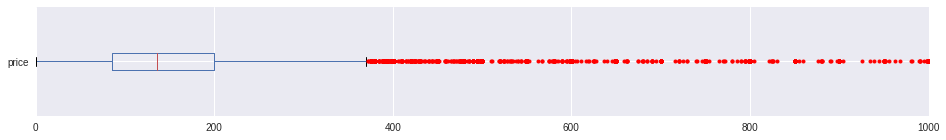

In [22]:
# boxplot of price column
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
df['price'].plot(kind='box', xlim=(0, 1000), vert=False, flierprops=red_square, figsize=(16,2));

The boxplot above shows quite a skewed distribution with a long tail of high-priced outliers. However, 75% of all rentals only cost up to 200 dollars. For this project, let's remove the extremely high priced rentals above $ 500/night to maintain comparability.

In [23]:
df.drop(df[df['price'] > 500].index, axis=0, inplace=True)
df['price'].describe()

count    15858.000000
mean       153.167613
std         96.976773
min          0.000000
25%         81.000000
50%        129.000000
75%        199.000000
max        500.000000
Name: price, dtype: float64

In [24]:
# investigate the proximity column
df['proximity'].describe()

count    15858.000000
mean      1103.209108
std       1426.258303
min          2.434337
25%        362.160411
50%        664.667243
75%       1367.706367
max      27884.559653
Name: proximity, dtype: float64

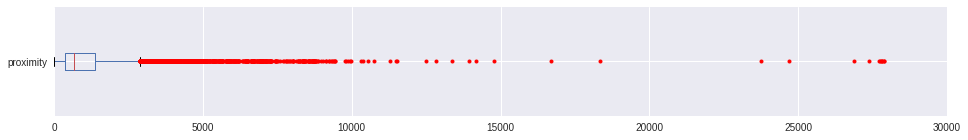

In [25]:
# boxplot of proximity column
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
df['proximity'].plot(kind='box', xlim=(0, 30000), vert=False, flierprops=red_square, figsize=(16,2));

The box plot shows a lot of outliers, with some listings upto 10-30 kms away from the nearest transport services. For this project, let's remove the listings which do not have transport services in a 10 km radius. 

In [26]:
df.drop(df[df['proximity'] > 10000].index, axis=0, inplace=True)
df['proximity'].describe()

count    15832.000000
mean      1074.061902
std       1196.852294
min          2.434337
25%        361.765903
50%        663.753687
75%       1360.397433
max       9971.946479
Name: proximity, dtype: float64

### Occupancy Estimate
One of the biggest issues with Airbnb is getting the occupancy rate for each host or for a market. Inside Airbnb, the website I sourced the data from, uses an occupancy model which they call the "San Francisco Model" with the following methodology:

1. A **Review Rate** of 50% is used to convert reviews to estimated bookings. Other administrative authorities are said to use a review rate of 72% (however this may be attributed to an unreliable source: Airbnb's CEO and co-founder Brian Chesky) - or one of 30.5% (based on comparing public data of reviews to the The New York Attorney General’s report on Airbnb released in October 2014.) Inside Airbnb chose 50% as it sits almost exactly between 72% and 30.5%. It basically means that only 50% of all visitors write a review. With that said, the number of reviews per month divided by the review rate equals an estimate of actual visitors.
2. An **average length** of stay for each city is usually published by Airbnb. This number multiplied by the estimated bookings for each listing over a period of time gives the occupancy rate.
3. Finally, the **income** can be calculated by multiplying the occupancy rate by the price and the time period of interest - here, 12 months:

> **Monthly Occupancy Rate = Average Length of Stay * (No. of reviews per Month/Review Rate)**
>
> According to the latest Business Insider Update, the average length of stay in Sydney is 5 nights
>
> **Yearly Income = Monthly Occupancy Rate * Price * 12 Months**

#### Modest Estimate

With a very modest review rate of 0.5, we are assuming that only ever second guest left a review.

In [27]:
avg_length_of_stay_sydney = 5.0
review_rate_modest = 0.5

# calculate the occupancy and round the result
df['modest_occupancy'] = round(avg_length_of_stay_sydney * (df['reviews_per_month']/review_rate_modest), 2)

# occupancy cannot be greater than 100% - are there any mistakes?
len(df[df['modest_occupancy'] > 100])

36

In [28]:
# let's drop occupancy rates > 100
df.drop(df[(df['modest_occupancy'] > 100)].index, axis=0, inplace=True)

# check the distribution
df['modest_occupancy'].describe()

count    15796.000000
mean        21.575561
std         14.079645
min         10.000000
25%         10.000000
50%         17.140000
75%         27.500000
max        100.000000
Name: modest_occupancy, dtype: float64

#### Optimistic Estimate

Now let's assume that the review rate is only 40%, which means only 40% of guests left a review. This will allow for a higher occupancy rate for each listing to provide a more optimistic overview of what we had before.

In [29]:
review_rate_optimistic = 0.4

# calculate the occupancy and round the result
df['optimistic_occupancy'] = round(avg_length_of_stay_sydney * (df['reviews_per_month']/review_rate_optimistic), 2)

# occupancy cannot be greater than 100% - are there any mistakes?
len(df[df['optimistic_occupancy'] > 100])

61

In [30]:
# let's drop occupancy rates > 100
df.drop(df[(df['optimistic_occupancy'] > 100)].index, axis=0, inplace=True)

# check the distribution
df['optimistic_occupancy'].describe()

count    15735.000000
mean        26.643745
std         16.830272
min         12.500000
25%         12.500000
50%         21.430000
75%         34.090000
max        100.000000
Name: optimistic_occupancy, dtype: float64

#### Comparing Occupancy Estimates

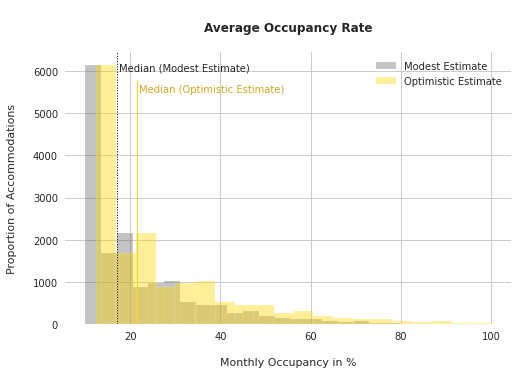

In [31]:
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))

sns.distplot(df['modest_occupancy'], kde=False, bins=20, color='dimgrey')
sns.distplot(df['optimistic_occupancy'], kde=False, bins=20, color='gold')

plt.title('\nAverage Occupancy Rate\n', fontweight='bold')
plt.legend(['Modest Estimate', 'Optimistic Estimate'])
plt.xlabel('\nMonthly Occupancy in %')
plt.ylabel('Proportion of Accommodations\n')

# draw and label a line with median value of modest estimate
plt.axvline(x=17.14, ymin=0, ymax=1, linewidth=1, linestyle=':', color='black')
plt.text(17.5, 6000, 'Median (Modest Estimate)')

# draw and label a line with median value of optimistic estimate
plt.axvline(x=21.43, ymin=0, ymax=0.9, linewidth=1, linestyle='-', color='gold')
plt.text(22.0, 5500, 'Median (Optimistic Estimate)', color='goldenrod');


### Income Estimate

Let's calculate the _modest income_ and _optimistic income_ using the modest and optimistic occupancy rates we have calculated for each listing.

In [32]:
df['modest_income'] = df['modest_occupancy'] * df['price'] * 12
df.modest_income.describe()

count     15735.000000
mean      38824.722761
std       35718.344326
min           0.000000
25%       15360.000000
50%       27876.720000
75%       50004.000000
max      452453.280000
Name: modest_income, dtype: float64

In [33]:
df['optimistic_income'] = df['optimistic_occupancy'] * df['price'] * 12
df.optimistic_income.describe()

count     15735.000000
mean      48531.018395
std       44647.905004
min           0.000000
25%       19200.000000
50%       34853.280000
75%       62493.000000
max      565506.720000
Name: optimistic_income, dtype: float64

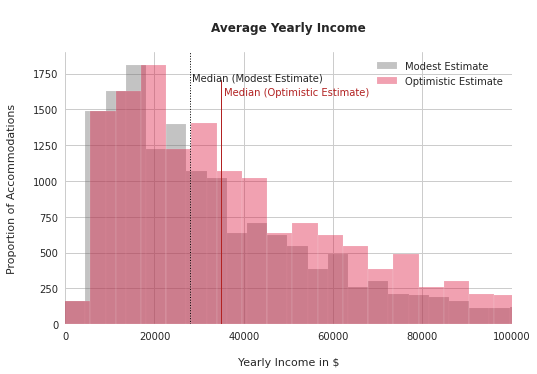

In [34]:
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))

sns.distplot(df['modest_income'], kde=False, bins=100, color='dimgrey')
sns.distplot(df['optimistic_income'], kde=False, bins=100, color='crimson')

plt.title('\nAverage Yearly Income\n', fontweight='bold')
plt.legend(['Modest Estimate', 'Optimistic Estimate'])
plt.xlabel('\nYearly Income in $')
plt.xlim((0,100000))
plt.ylabel('Proportion of Accommodations\n')

# draw and label a line with median value of modest estimate
plt.axvline(x=27876.720000, ymin=0, ymax=1, linewidth=1, linestyle=':', color='black')
plt.text(28500, 1700, 'Median (Modest Estimate)')

# draw and label a line with median value of optimistic estimate
plt.axvline(x=34853.280000, ymin=0, ymax=0.9, linewidth=1, linestyle='-', color='firebrick')
plt.text(35500, 1600, 'Median (Optimistic Estimate)', color='firebrick');

## Exploratory Data Analysis

### Correlation Heat Map

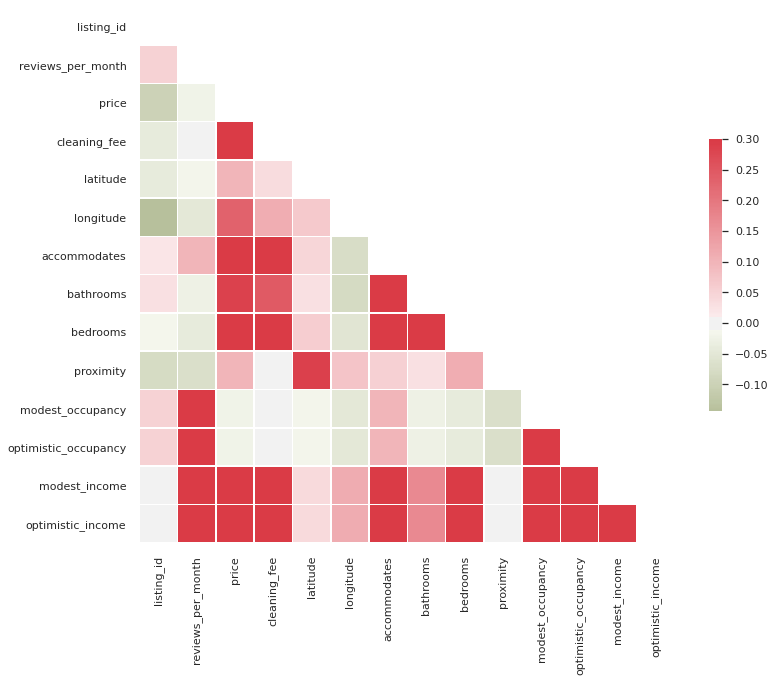

In [35]:
%matplotlib inline

sns.set(style="white")
corr = df.corr()

# generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# set up the matplotlib figure
fig, ax = plt.subplots(figsize=(12, 10))

# generate a custom diverging colormap
cmap = sns.diverging_palette(100, 10, as_cmap=True)

# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink":.5});

There is reason to believe that

a) the number of people that can be accommodated as an indicator for size or capacity and

b) the latitude as a proxy for location may help explaining the demand.
(The feature reviews_per_month is what we used to estimate the occupancy, so no wonder the correlation is a vivid red.)

I assume there might be also some seasonality that strongly influences the demand. Furthermore, I believe that the so-called super host status does benefit these hosts, who probably get far more guests than standard hosts. As the heat map only uses numeric columns, it can't show any such relationship — so let's walk through all of these factors to visually investigate their effect on demand:

### Seasonal Demand

To examine if there's an underlying seasonality, let's split the dataset we loaded at the very beginning by year. We'll repeat the exact same steps we used earlier to pull out the full calendar year.

In [36]:
df_raw.date.describe()

count                  642498
unique                   3152
top       2020-01-01 00:00:00
freq                     2227
first     2009-12-05 00:00:00
last      2020-03-16 00:00:00
Name: date, dtype: object

In [37]:
count_2018 = df_raw[df_raw["date"].isin(pd.date_range('2018-01-01', '2018-12-31'))]
count_2017 = df_raw[df_raw["date"].isin(pd.date_range('2017-01-01', '2017-12-31'))]
count_2016 = df_raw[df_raw["date"].isin(pd.date_range('2016-01-01', '2016-12-31'))]
count_2015 = df_raw[df_raw["date"].isin(pd.date_range('2015-01-01', '2015-12-31'))]

# set the date as index and sort by index
count_2018 = count_2018.set_index('date').sort_index()
count_2017 = count_2017.set_index('date').sort_index()
count_2016 = count_2016.set_index('date').sort_index()
count_2015 = count_2015.set_index('date').sort_index()

# calculate reviews per month          

count_2018_monthly = (count_2018.groupby([pd.Grouper(freq='M'), 'listing_id'])
                            .agg({'review_count':'count'})
                            .rename(columns={'review_count':'reviews_per_month_18'})
                            .reset_index())
count_2017_monthly = (count_2017.groupby([pd.Grouper(freq='M'), 'listing_id'])
                            .agg({'review_count':'count'})
                            .rename(columns={'review_count':'reviews_per_month_17'})
                            .reset_index())
count_2016_monthly = (count_2016.groupby([pd.Grouper(freq='M'), 'listing_id'])
                            .agg({'review_count':'count'})
                            .rename(columns={'review_count':'reviews_per_month_16'})
                            .reset_index())
count_2015_monthly = (count_2015.groupby([pd.Grouper(freq='M'), 'listing_id'])
                            .agg({'review_count':'count'})
                            .rename(columns={'review_count':'reviews_per_month_15'})
                            .reset_index())

# flatten the multi-index
count_2018_monthly.columns = ['date', 'listing_id', 'reviews_per_month_18']
count_2017_monthly.columns = ['date', 'listing_id', 'reviews_per_month_17']
count_2016_monthly.columns = ['date', 'listing_id', 'reviews_per_month_16']
count_2015_monthly.columns = ['date', 'listing_id', 'reviews_per_month_15']

# set date as index
count_2018_monthly.set_index('date', inplace=True)
count_2017_monthly.set_index('date', inplace=True)
count_2016_monthly.set_index('date', inplace=True)
count_2015_monthly.set_index('date', inplace=True)

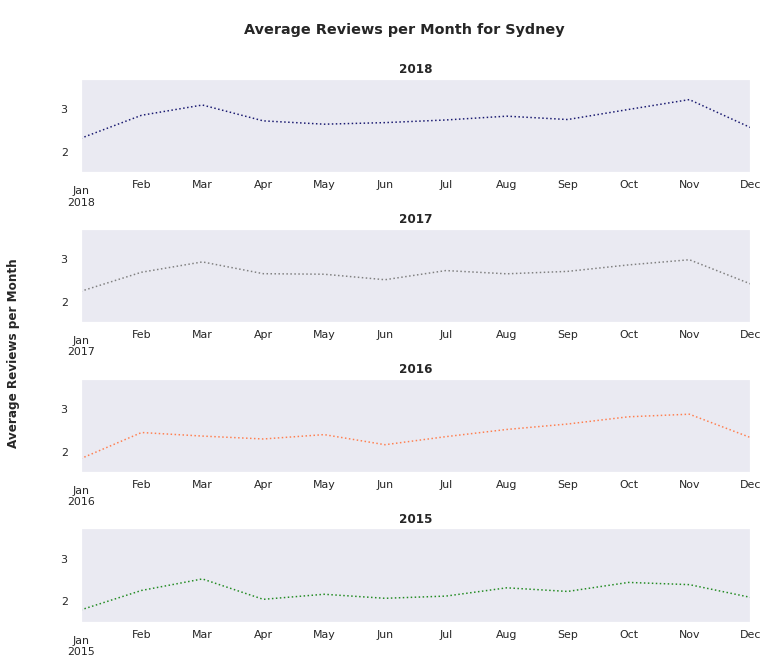

In [38]:
sns.set(style="dark")
fig, axes = plt.subplots(4, 1, figsize=(12,10))

for ax in axes:
    ax.set_ylim(1.5, 3.7)

sub_1 = count_2018_monthly.groupby('date')['reviews_per_month_18'].mean()
sub_1.plot(ax=axes[0], color='midnightblue', style=':')
axes[0].set_title('2018', fontweight='bold')
axes[0].set_xlabel('') 

sub_2 = count_2017_monthly.groupby('date')['reviews_per_month_17'].mean()
sub_2.plot(ax=axes[1], color='grey', style=':')
axes[1].set_title('2017', fontweight='bold')
axes[1].set_xlabel('') 

sub_3 = count_2016_monthly.groupby('date')['reviews_per_month_16'].mean()
sub_3.plot(ax=axes[2], color='coral', style=':')
axes[2].set_title('2016', fontweight='bold')
axes[2].set_xlabel('') 

sub_4 = count_2015_monthly.groupby('date')['reviews_per_month_15'].mean()
sub_4.plot(ax=axes[3], color='forestgreen', style=':')
axes[3].set_title('2015', fontweight='bold')
axes[3].set_xlabel('') 

# adjust space between subplots and set a title
plt.subplots_adjust(hspace = 0.6)
plt.suptitle('\nAverage Reviews per Month for Sydney\n', fontweight='bold')

# plot common y-label
fig.text(0.04, 0.5, 'Average Reviews per Month', fontweight='bold', va='center', rotation='vertical');

It's quite visible that there is a very clear seasonal demand for listings in Sydney. Demand appears to peak once early in the year during March, and then later again during November. This might primarily be due to a climate factor - where temperatures during March and November are much amenable than the rest of the year.

### Demand by Super Host status

In [39]:
# check super host column for NaN's
df.host_is_superhost.isna().sum()

1

In [40]:
# replace NaN's with value 'false' for not being a superhost
df.host_is_superhost.fillna(value='f', inplace=True)
df.host_is_superhost.isna().sum()

0

What do the differences between super host and normal host look like?

([<matplotlib.patches.Wedge at 0x7f7b3c99b9a0>,
 [Text(0.7016401030017977, 0.8471724534353245, 'Super Hosts'),
  Text(-0.701640103001798, -0.8471724534353242, 'Standard Hosts')],
 [Text(0.8164539380384553, 0.9858006730883776, '27.98%'),
  Text(-0.8164539380384558, -0.9858006730883772, '72.02%')])

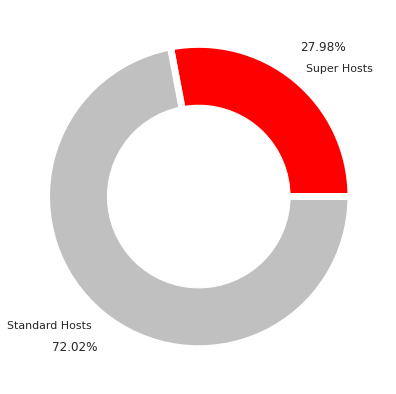

In [41]:
# assign the data
super_host    = df.host_is_superhost.value_counts()['t']
no_super_host = df.host_is_superhost.value_counts()['f']
names = ['Super Hosts','Standard Hosts']
size  = [super_host, no_super_host]

# create a pie chart
plt.pie(size, labels=names, colors=['red','silver'], 
        autopct='%.2f%%', pctdistance=1.28,
        wedgeprops={'linewidth':7, 'edgecolor':'white'})

# create circle for the center of the plot to make the pie look like a donut
my_circle = plt.Circle((0,0), 0.6, color='white')

# plot the donut chart
fig = plt.gcf()
fig.set_size_inches(7,7)
fig.gca().add_artist(my_circle)
plt.show()

In [42]:
# the overall median differences between superhosts and standard hosts
df.groupby('host_is_superhost')['modest_occupancy'].agg(np.median)

host_is_superhost
f    15.00
t    23.33
Name: modest_occupancy, dtype: float64

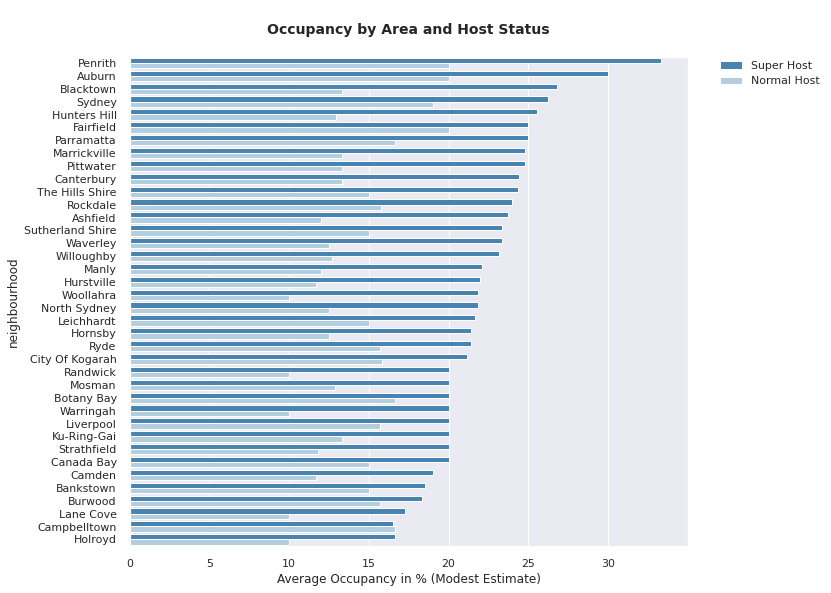

In [43]:
# group by neighbourhood and by status, then take the median occupancy
df_grouped = pd.DataFrame(df.groupby(['neighbourhood', 'host_is_superhost'])['modest_occupancy'].agg(np.median))
df_grouped.sort_values(by='modest_occupancy', ascending=False, inplace=True)
df_grouped.reset_index(inplace=True)

# plot grouped dataframe with seaborn
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(10, 9))
sns.barplot(x='modest_occupancy', y='neighbourhood', hue='host_is_superhost', hue_order=['t', 'f'], 
            data=df_grouped, palette="Blues_r")

# add title and axis label
ax.set_title('\nOccupancy by Area and Host Status\n', fontsize=14, fontweight='bold')
ax.set(xlabel='Average Occupancy in % (Modest Estimate)')

# rename legend labels & put legend outside plot
handles, labels = ax.get_legend_handles_labels()
ax.legend((handles), ('Super Host', 'Normal Host'), bbox_to_anchor=(1.05, 1), borderaxespad=0.);

In [44]:
# the overall median differences between superhosts and standard hosts
df.groupby('host_is_superhost')['modest_income'].agg(np.median)

host_is_superhost
f    24000.00
t    37833.12
Name: modest_income, dtype: float64

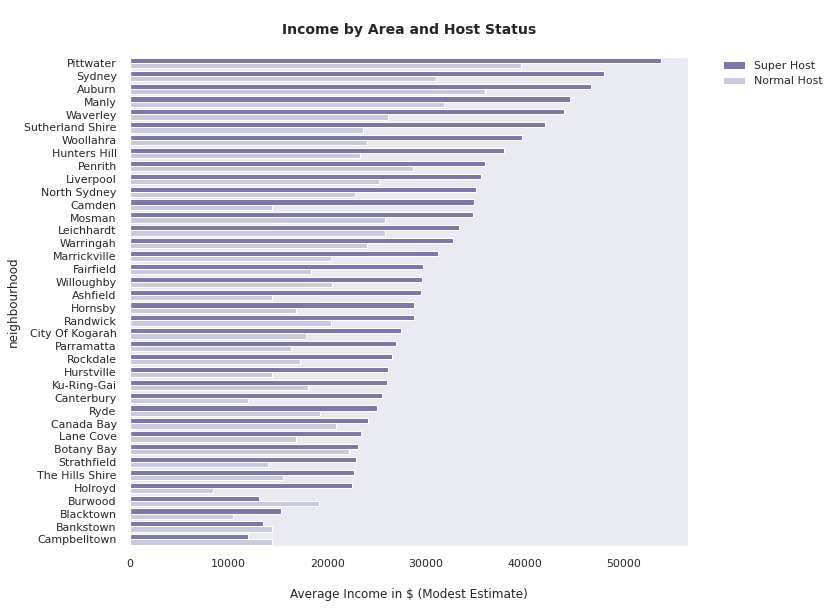

In [45]:
df_grouped = pd.DataFrame(df.groupby(['neighbourhood', 'host_is_superhost'])['modest_income'].agg(np.median))
df_grouped.sort_values(by='modest_income', ascending=False, inplace=True)
df_grouped.reset_index(inplace=True)

# plot grouped dataframe with seaborn
sns.set_style('dark')
fig, ax = plt.subplots(figsize=(10, 9))
sns.barplot(x='modest_income', y='neighbourhood', hue='host_is_superhost', hue_order=['t', 'f'], 
            data=df_grouped, palette="Purples_r")

# add title and axis label
ax.set_title('\nIncome by Area and Host Status\n', fontsize=14, fontweight='bold')
ax.set(xlabel='\nAverage Income in $ (Modest Estimate)')

# rename legend labels & put legend outside plot
handles, labels = ax.get_legend_handles_labels()
ax.legend((handles), ('Super Host', 'Normal Host'), bbox_to_anchor=(1.25, 1), borderaxespad=0.);

It's quite clear that super hosts are earning heaps more than normal hosts!

### Demand by Neighbourhood

_Lollipop charts with 2 observations_

In [46]:
def lollipop_with_2(dataframe, about, y_col, x1_col, x2_col):
    ''' Function that creates a lollipop chart with 
    two observations (x-values) per group (y-value). '''
       
    # set style
    sns.set_style("dark")
    
    # prepare data
    df_plot = dataframe[[y_col, x1_col, x2_col]].groupby(y_col).apply(lambda x: x.mean())
    df_plot.sort_values(x1_col, inplace=True)
    df_plot.reset_index(inplace=True)
    # draw plot
    fig, ax = plt.subplots(figsize=(10,15))
    ax.hlines (y=df_plot.index, xmin=df_plot[x1_col], xmax=df_plot[x2_col], color='grey', alpha=0.7, linewidth=2)
    ax.scatter(y=df_plot.index, x=df_plot[x1_col], s=75, color='skyblue', alpha=0.7, label=x1_col)
    ax.scatter(y=df_plot.index, x=df_plot[x2_col], s=75, color='darkblue', alpha=0.7, label=x2_col)
    ax.legend()
    
    # title, label, ticks and xlim
    ax.set_title('\nAverage ' + about + ' by District\n', fontdict={'size':12, 'weight':'bold'})
    ax.set_xlabel('\n' + about)
    ax.set_yticks(df_plot.index)
    ax.set_yticklabels(df_plot[y_col], rotation=0, 
                       fontdict={'horizontalalignment': 'right', 'size':12})
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

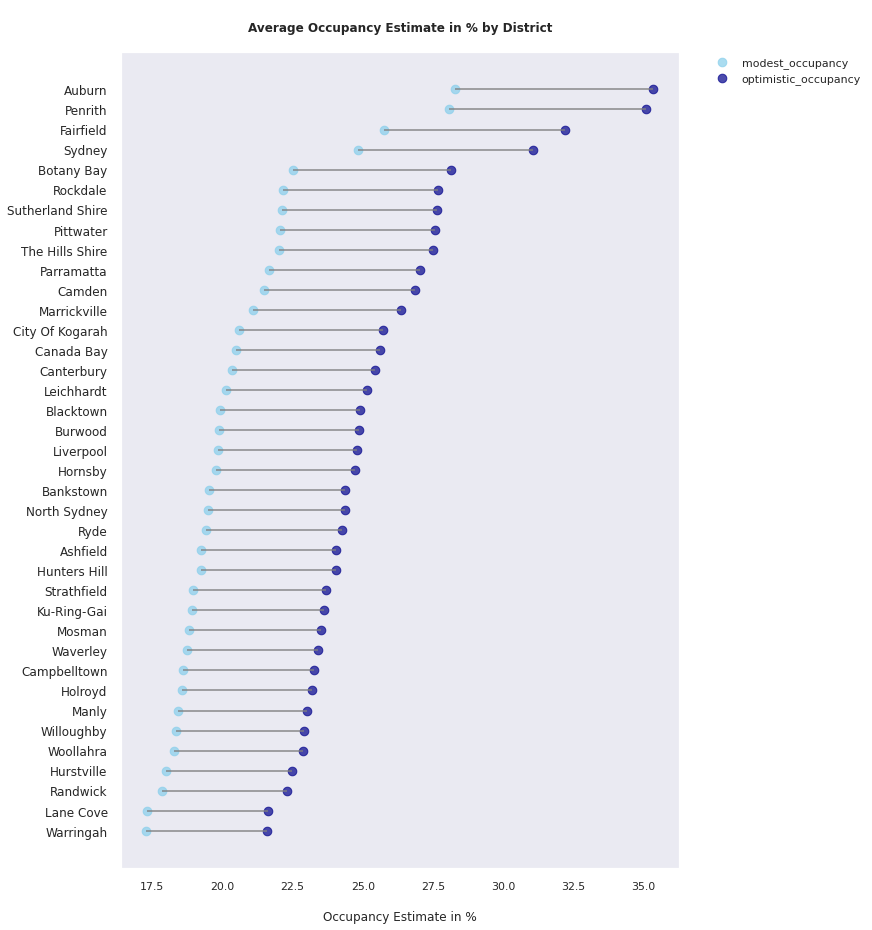

In [47]:
lollipop_with_2(df, 'Occupancy Estimate in %', 'neighbourhood', 'modest_occupancy', 'optimistic_occupancy')


Interestingly enough, areas such as Auburn, Penrith and Fairfield have relatively high occupancy rates. You would expect Sydney CBD (Sydney) to have a high occupancy rate, but the districts mentioned above are quite surprising to be at the top!

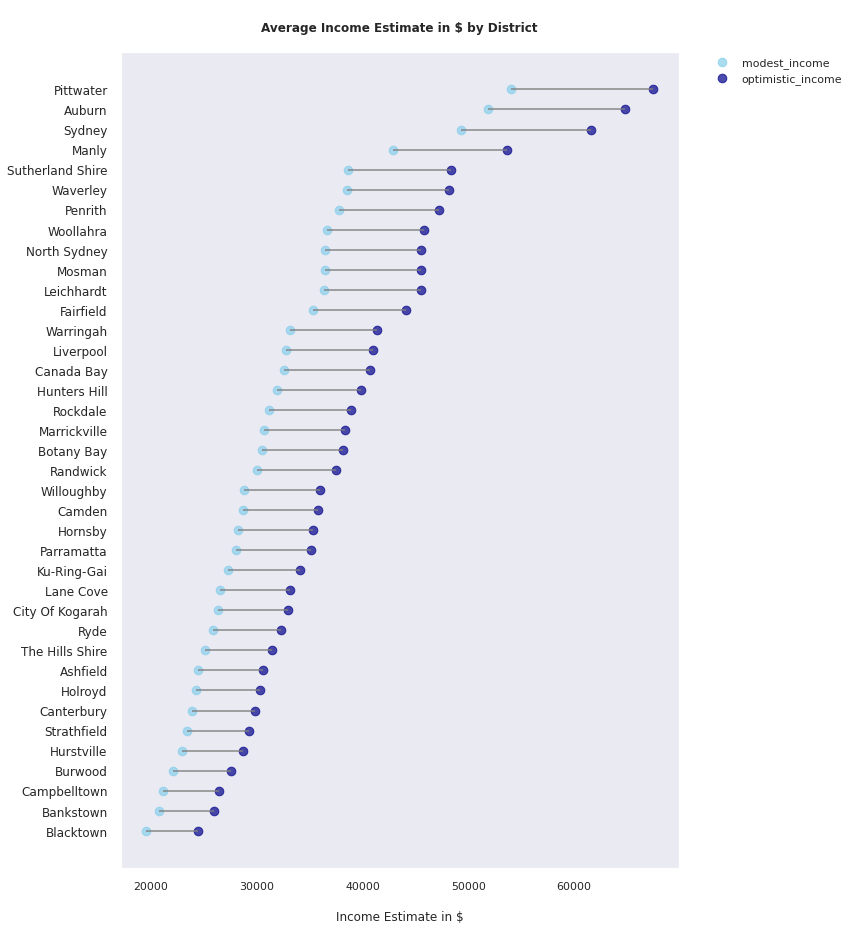

In [48]:
lollipop_with_2(df, 'Income Estimate in $', 'neighbourhood', 'modest_income', 'optimistic_income')

However, when measuring income estimates per region, Sydney CBD, and many of the areas close to beaches or attraction points rank higher. Quite surprisingly, Auburn is still high in terms of modest and optimistic income - which is quite puzzling to me.

### Demand by proximity to transport

_Slight modification to lollipop to accomodate binning for proximity. Let's look at the top 5 districts by modest occupancy._

In [77]:
def lollipop_with_proximity(dataframe, about, y_col, x1_col, x2_col, districts, discrete_bins=False):
    ''' Function that creates a lollipop chart with 
    two observations (x-values) per group (y-value). '''
       
    # set style
    sns.set_style("dark")
    
    # prepare data
    df = dataframe.copy()
    df = df[df['neighbourhood'].isin(districts)]
    bins = pd.IntervalIndex.from_tuples([(0, 2000), (2000, 4000), (4000, 6000), (6000, 8000), (8000, 10000)])
    df['proximity-range'] = df.groupby(y_col)[['proximity']].transform(lambda x: pd.cut(x, bins=bins if discrete_bins else 5).astype(str))
    df_plot = df[[y_col, x1_col, x2_col, 'proximity-range']].groupby([y_col, 'proximity-range'], as_index=False).apply(lambda x: x.mean())
    df_plot.reset_index(drop=True)
    df_plot.reset_index(level=[0,1], inplace=True)
    # Sort by distance
    df_plot = pd.DataFrame(
        sorted(df_plot.values, key=lambda x: float(x[1].split(',')[0][1:])), 
        columns=df_plot.columns
    ).reset_index(drop=True)
    
    # draw plot
    fig, ax = plt.subplots(figsize=(10,5))
    ax.hlines (y=df_plot.index, xmin=df_plot[x1_col], xmax=df_plot[x2_col], color='grey', alpha=0.7, linewidth=2)
    ax.scatter(y=df_plot.index, x=df_plot[x1_col], s=75, color='skyblue', alpha=0.7, label=x1_col)
    ax.scatter(y=df_plot.index, x=df_plot[x2_col], s=75, color='darkblue', alpha=0.7, label=x2_col)
    ax.legend()
    
    # title, label, ticks and xlim
    ax.set_title('\nAverage ' + about + ' by District\n', fontdict={'size':12, 'weight':'bold'})
    ax.set_xlabel('\n' + about)
    ax.set_yticks(df_plot.index)
    ax.set_yticklabels(df_plot[y_col] + " " + df_plot['proximity-range'], rotation=0, 
                       fontdict={'horizontalalignment': 'right', 'size':12})
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

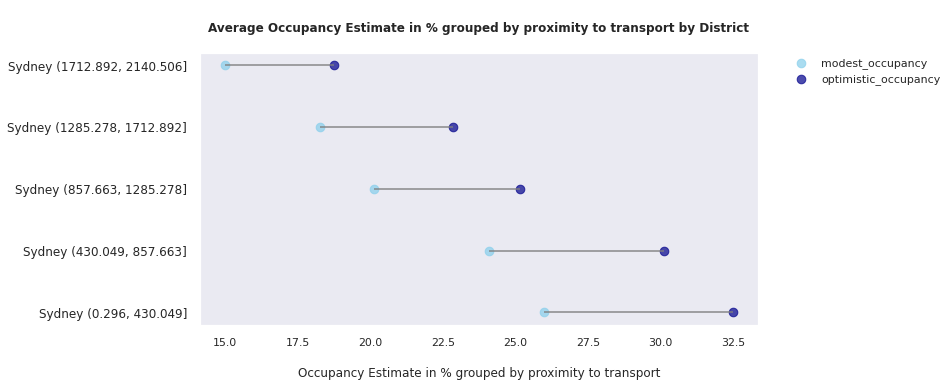

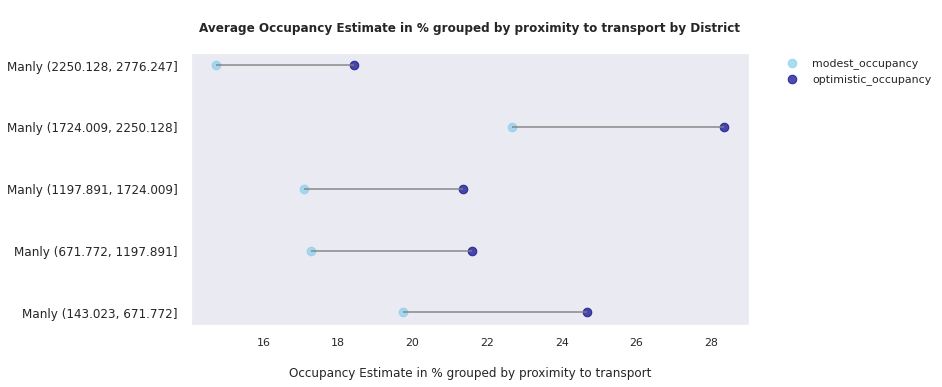

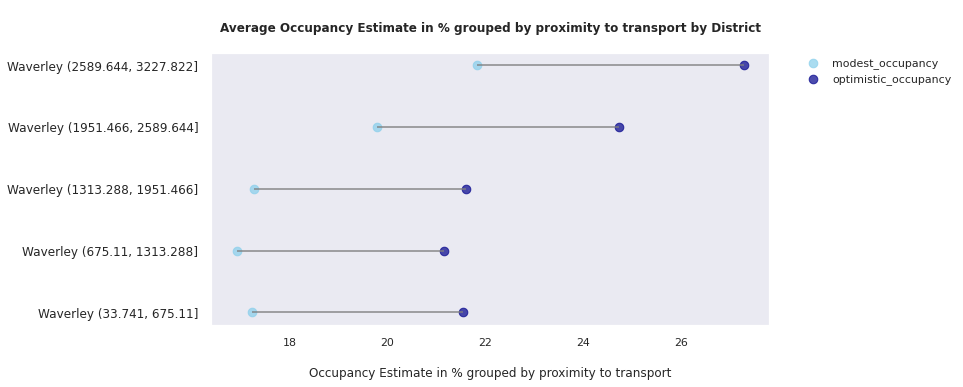

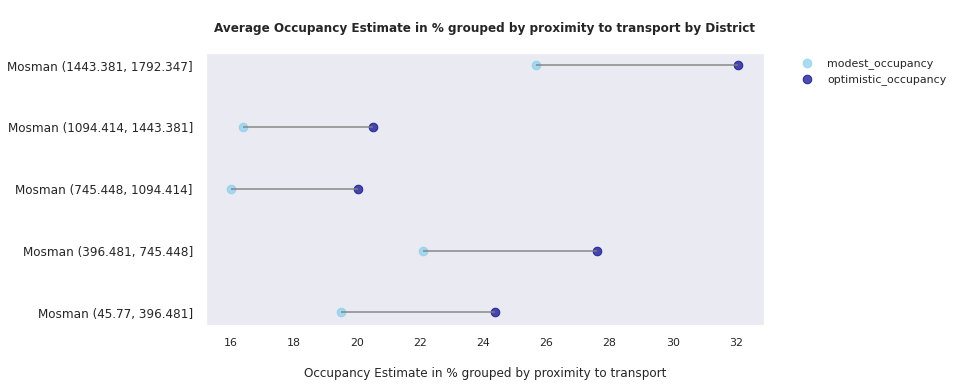

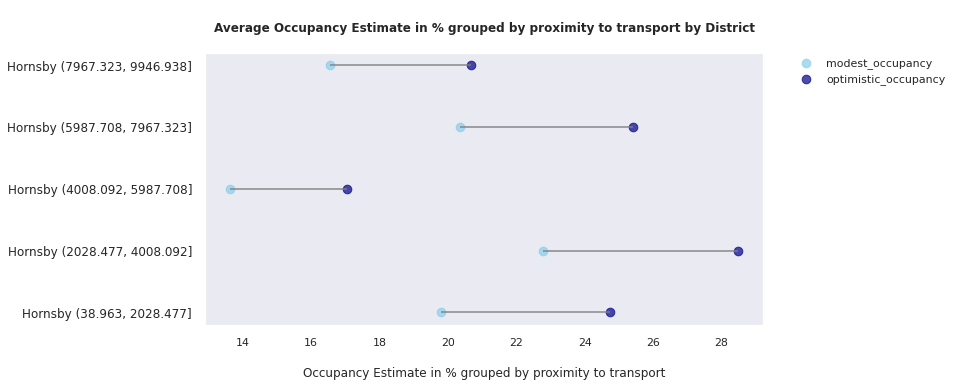

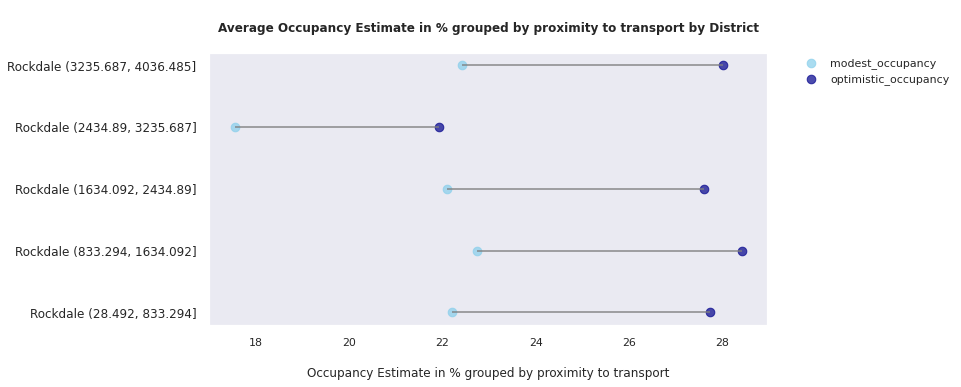

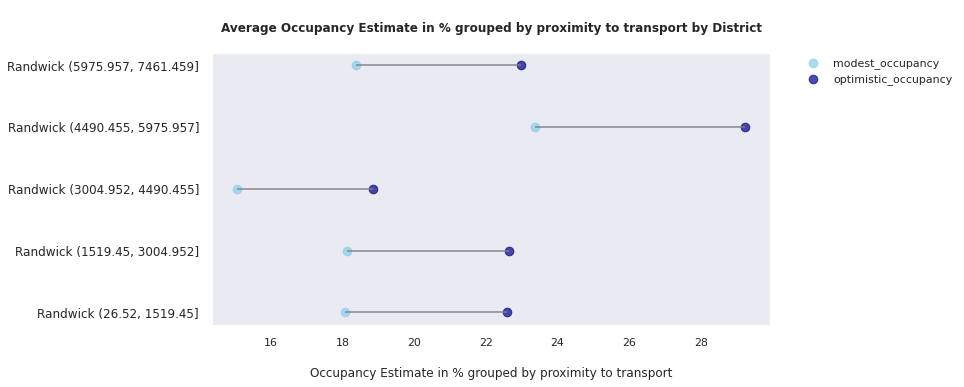

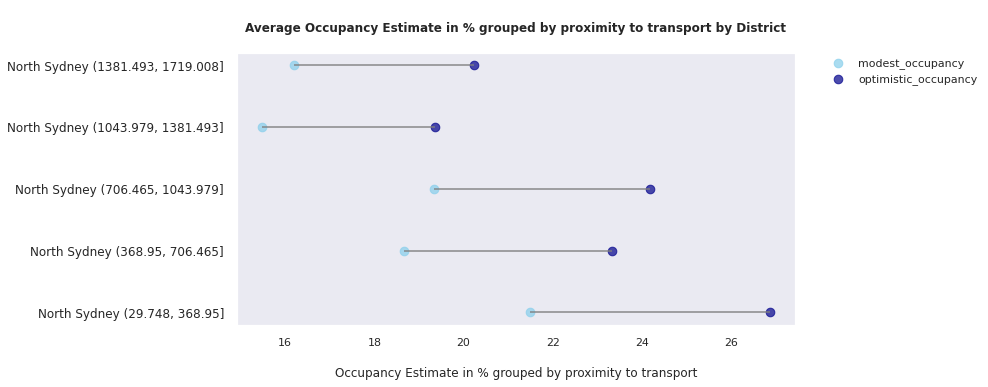

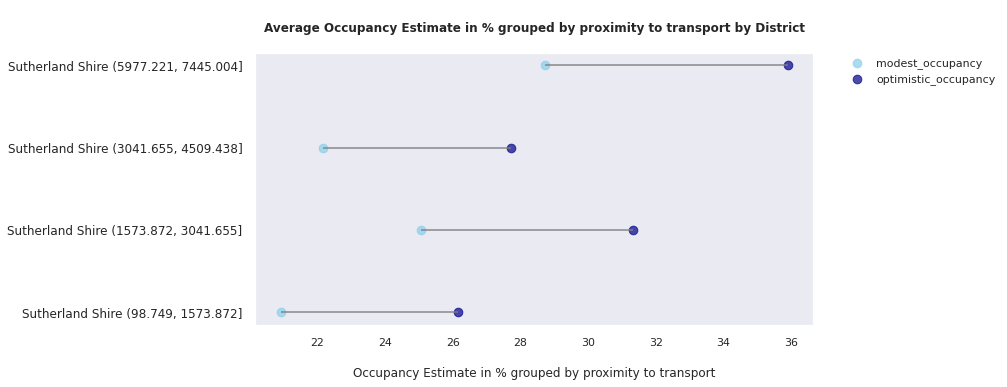

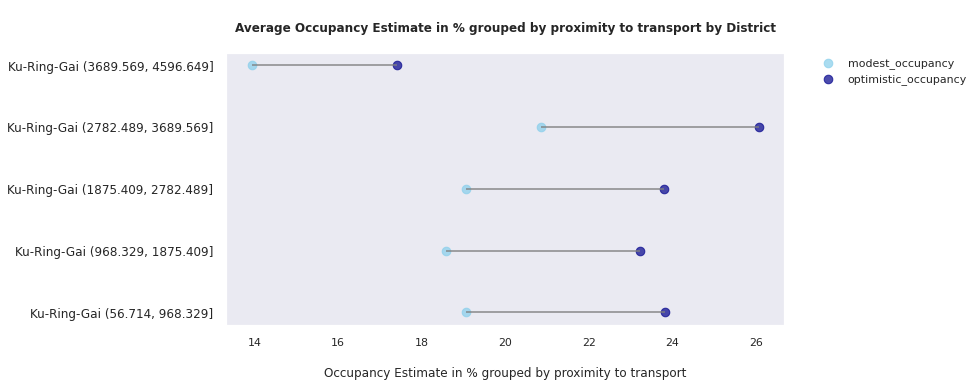

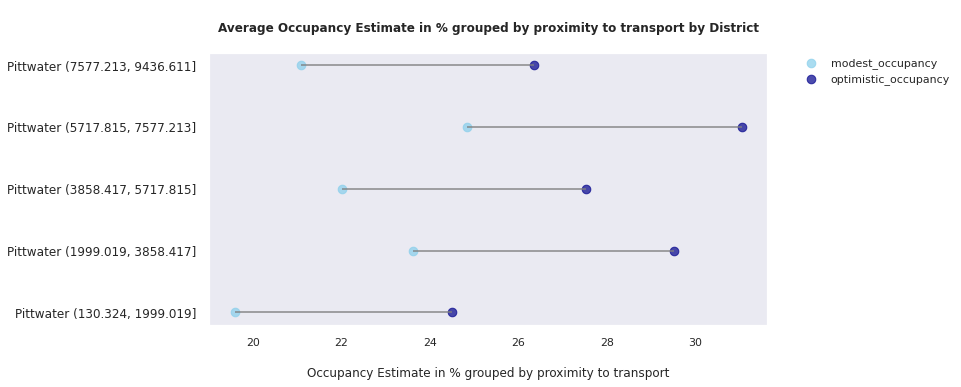

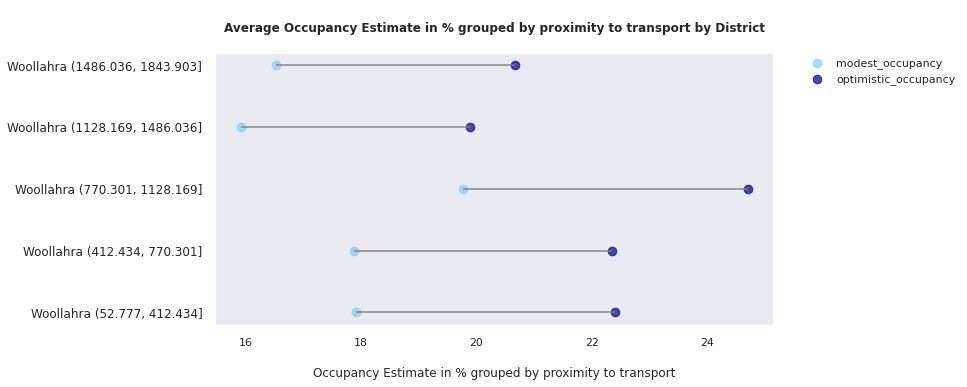

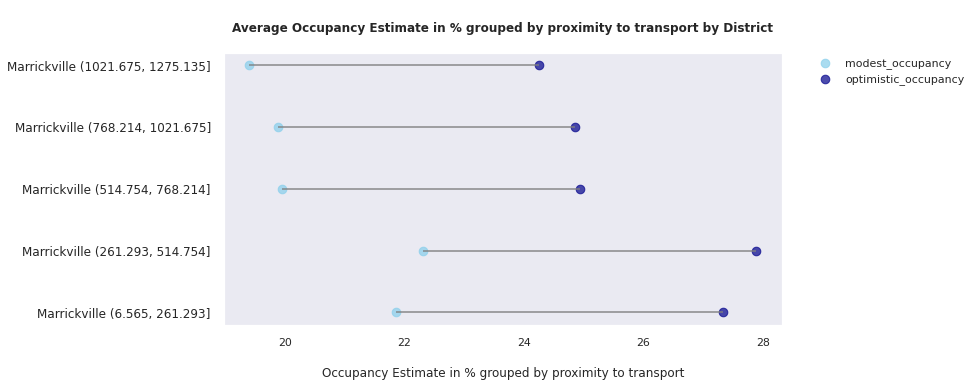

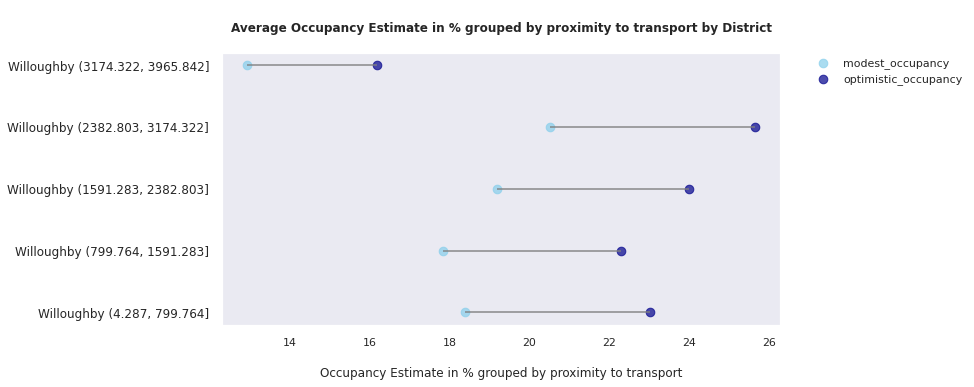

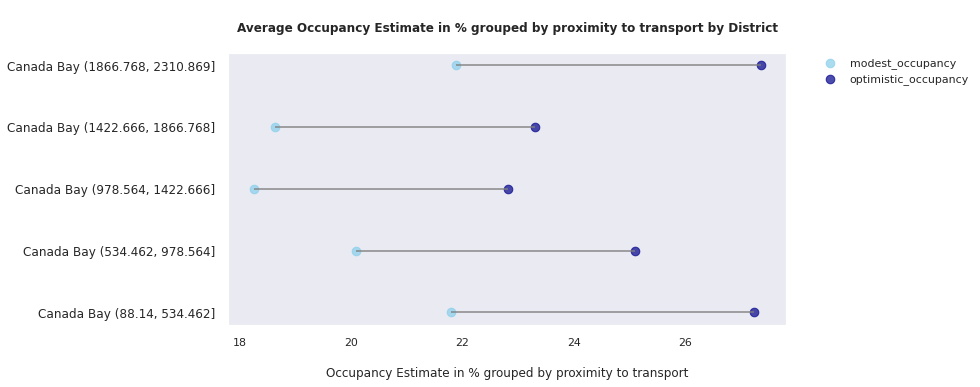

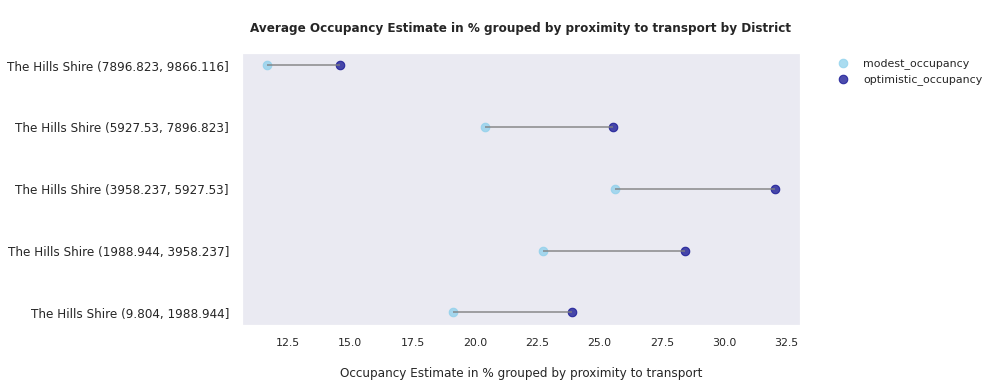

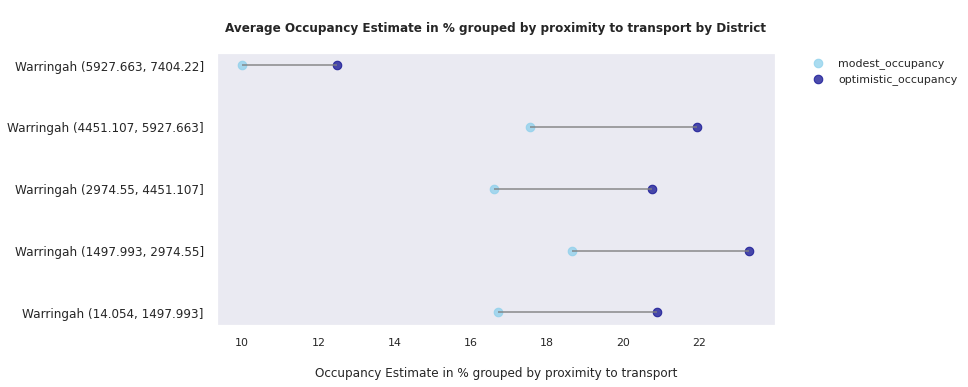

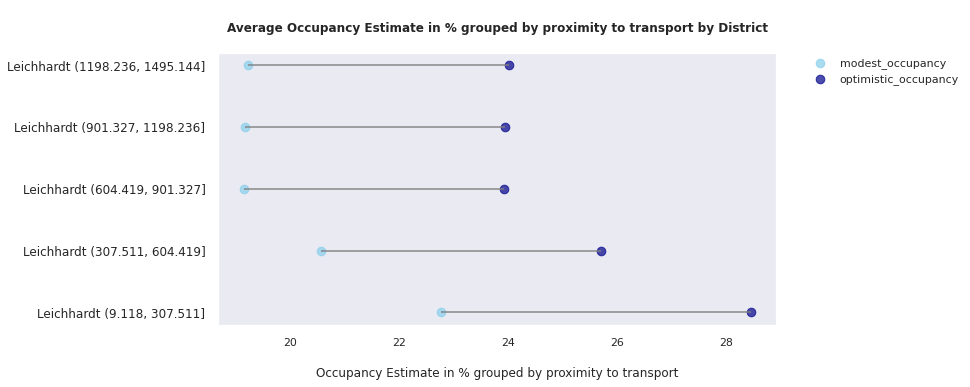

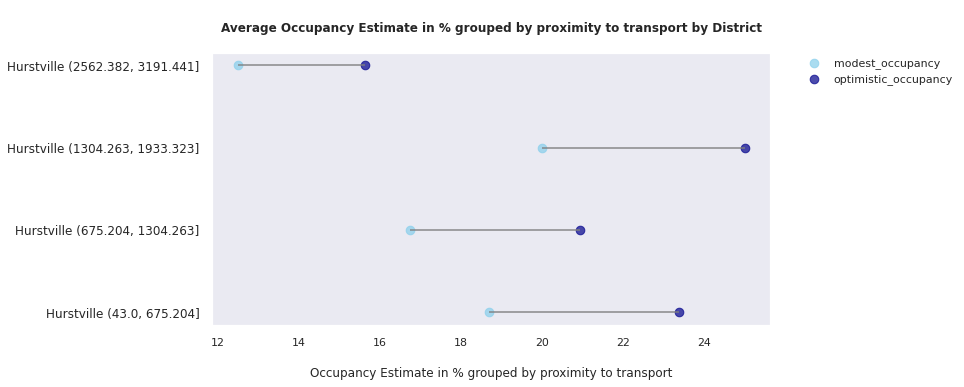

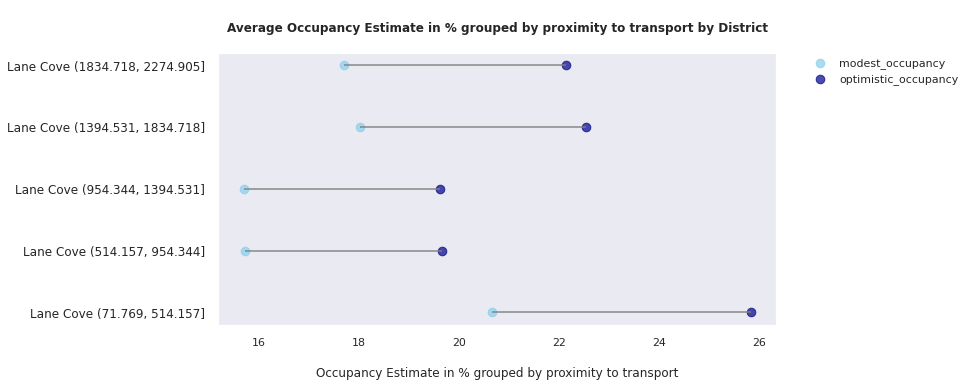

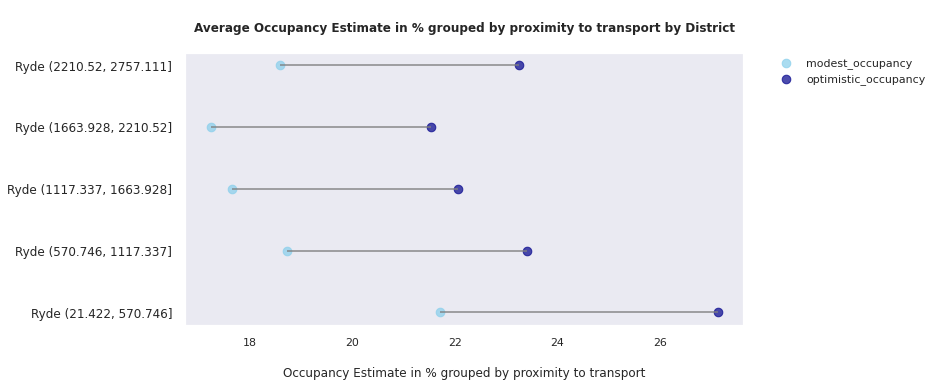

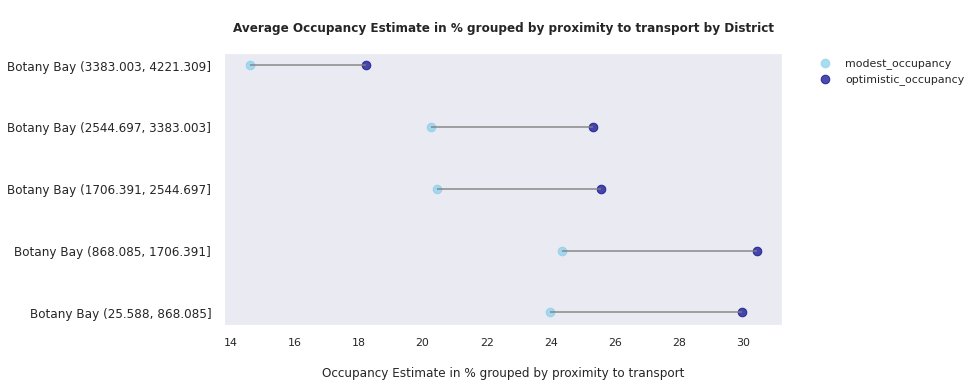

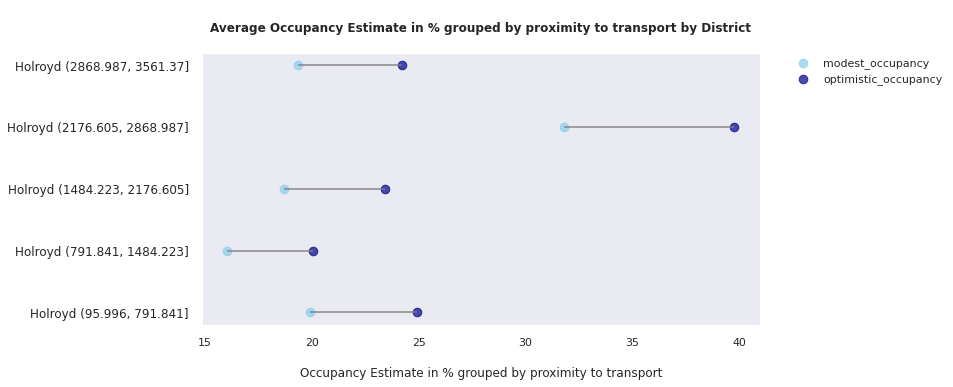

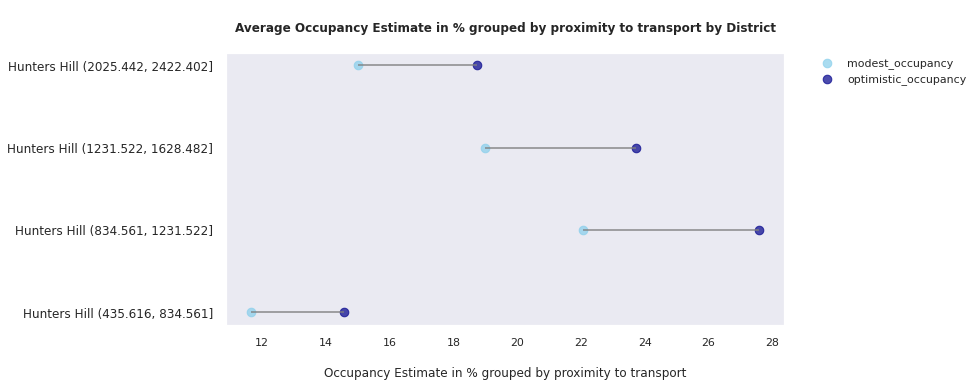

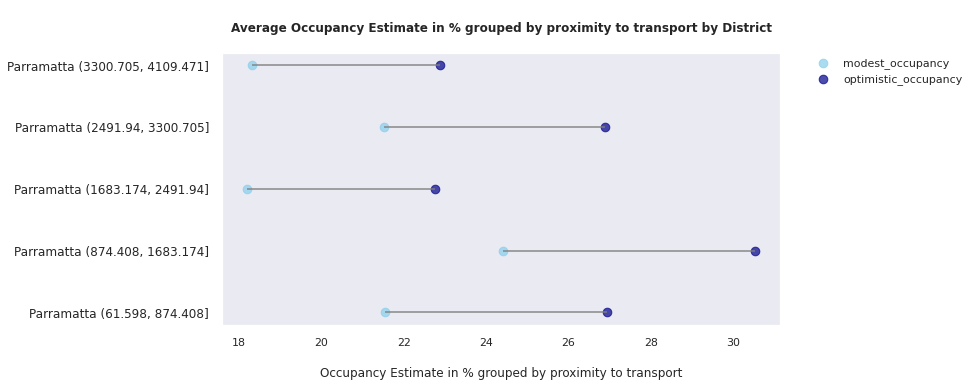

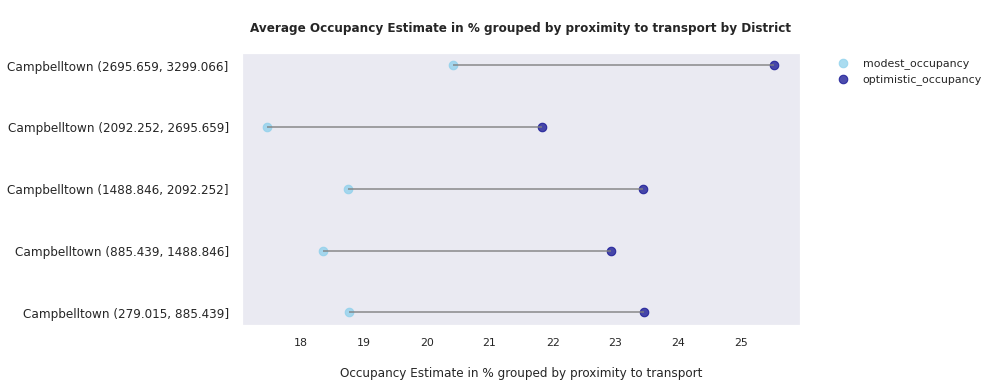

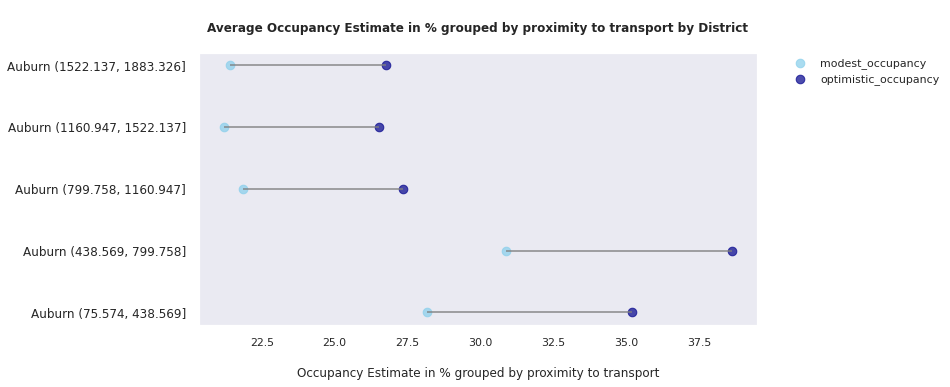

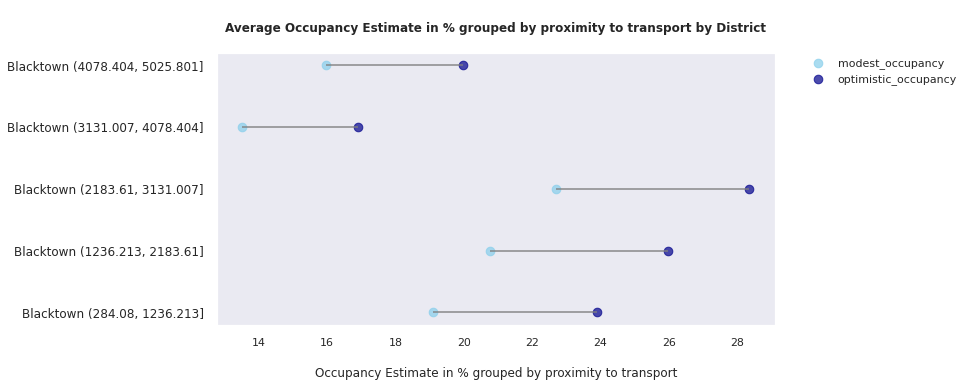

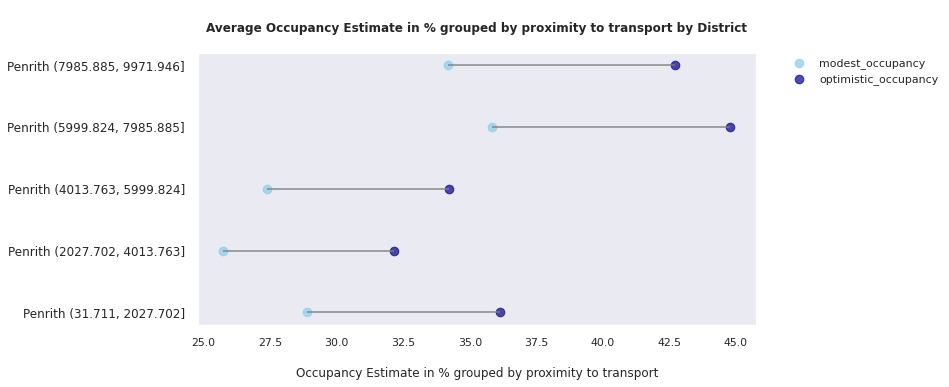

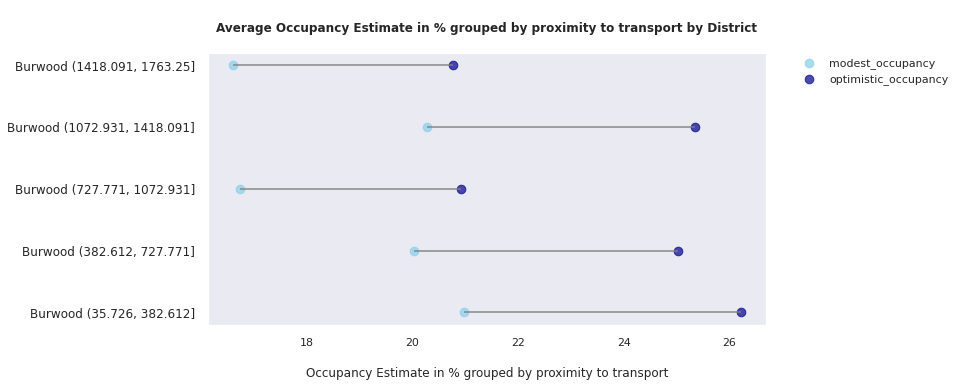

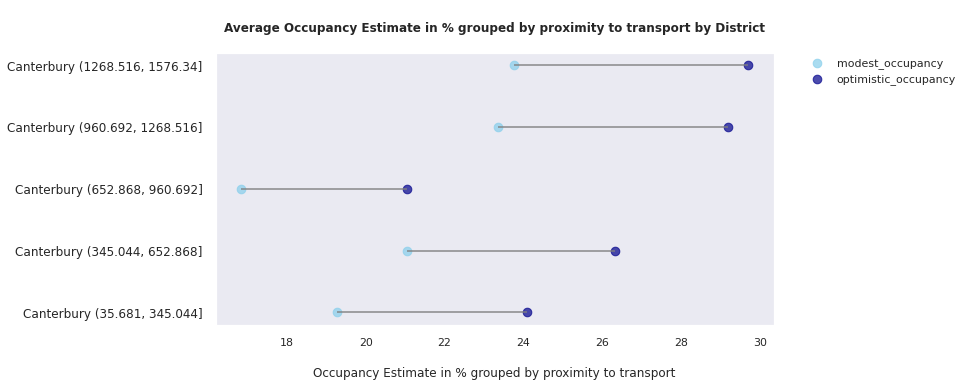

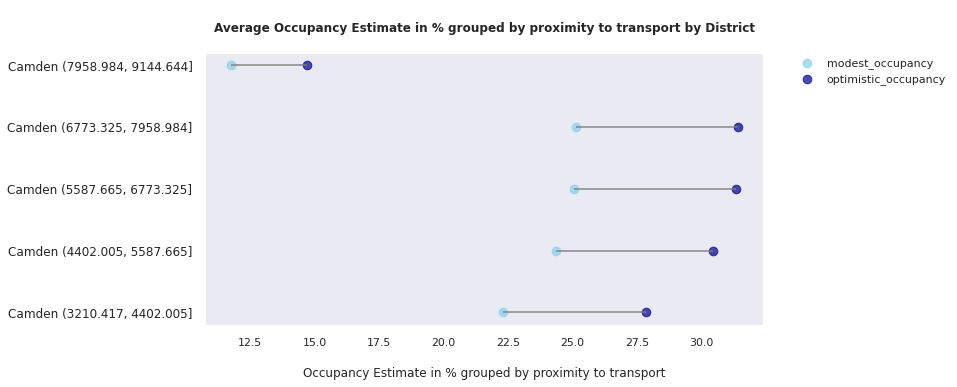

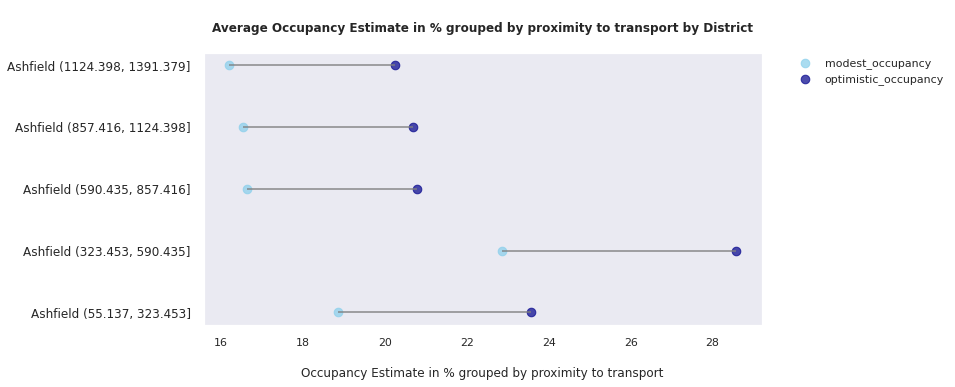

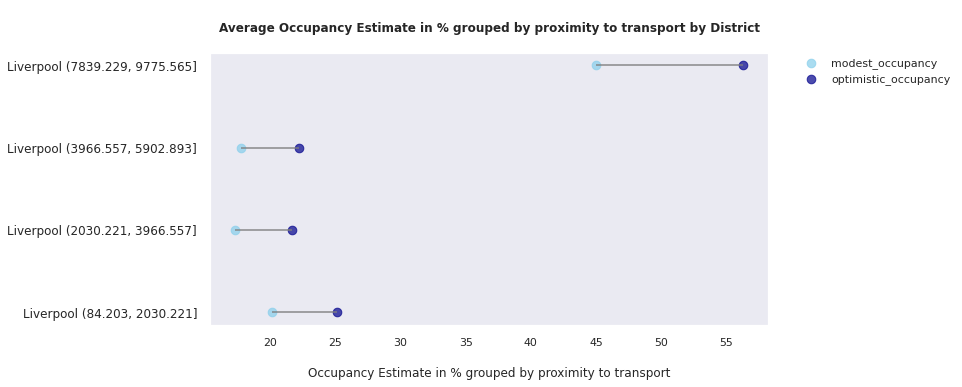

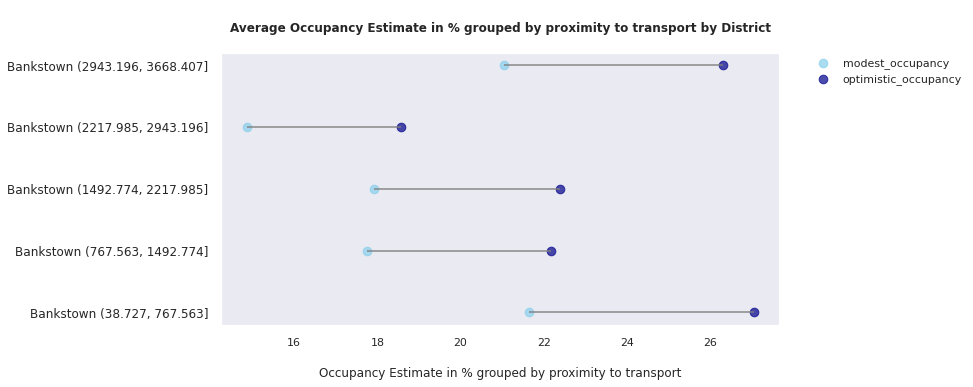

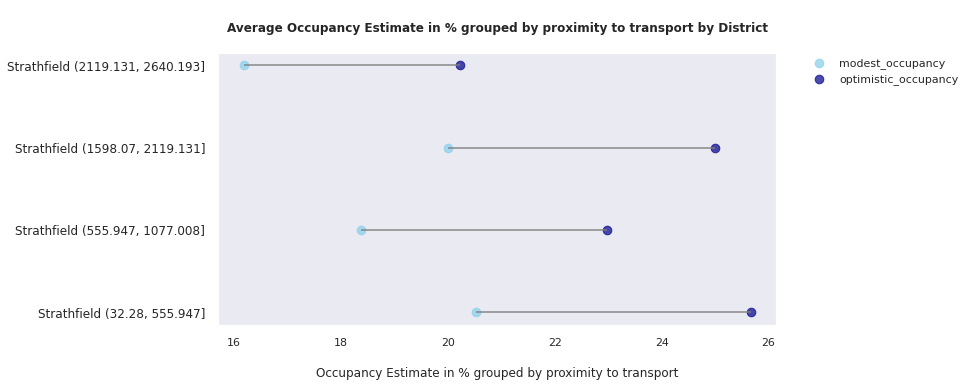

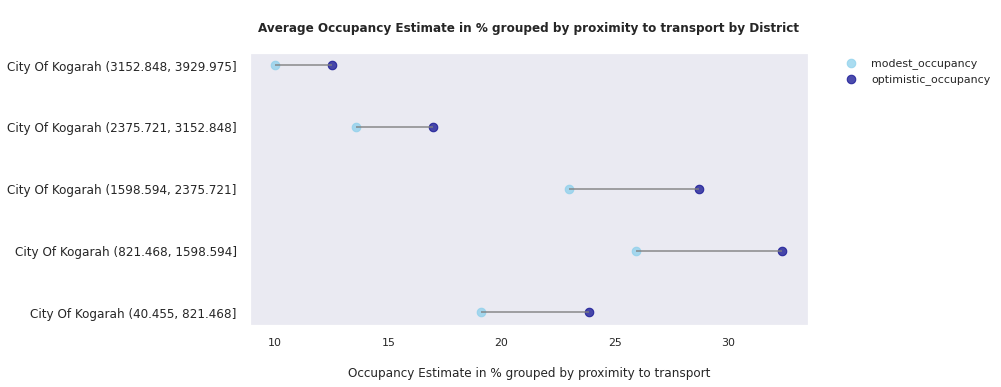

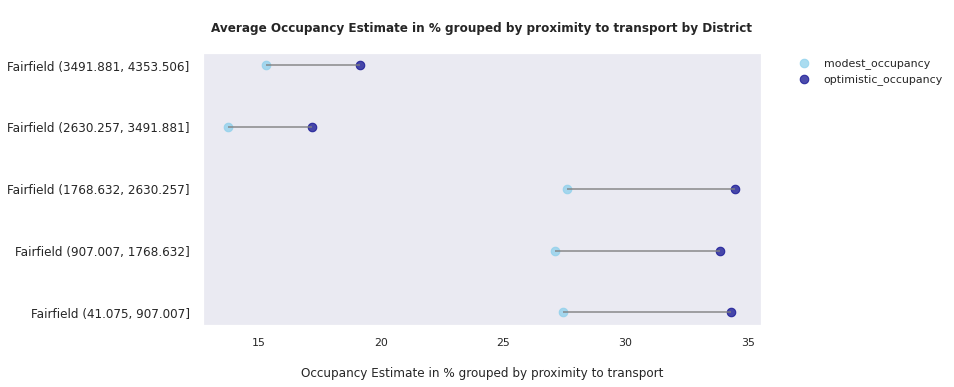

In [75]:
for district in list(df.neighbourhood.unique()):
    lollipop_with_proximity(df, 
                            'Occupancy Estimate in % grouped by proximity to transport', 
                            'neighbourhood', 
                            'modest_occupancy', 
                            'optimistic_occupancy',
                            [district],
                            discrete_bins=False
                           )

Even though it's quite a stretch, there appears to be a small pattern in which occupancy estimates differ per district. 

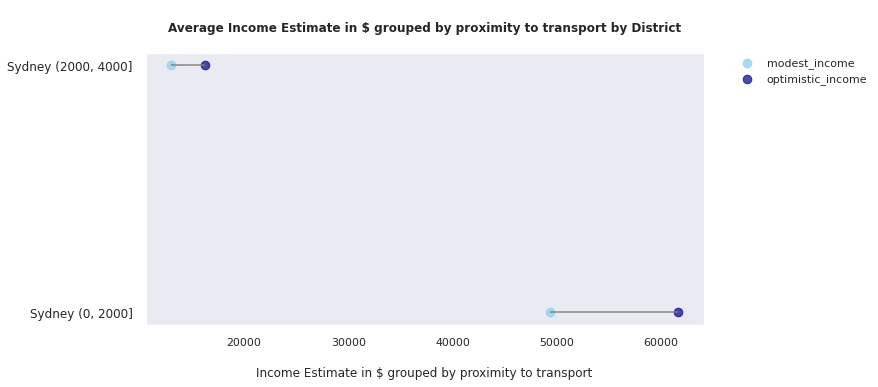

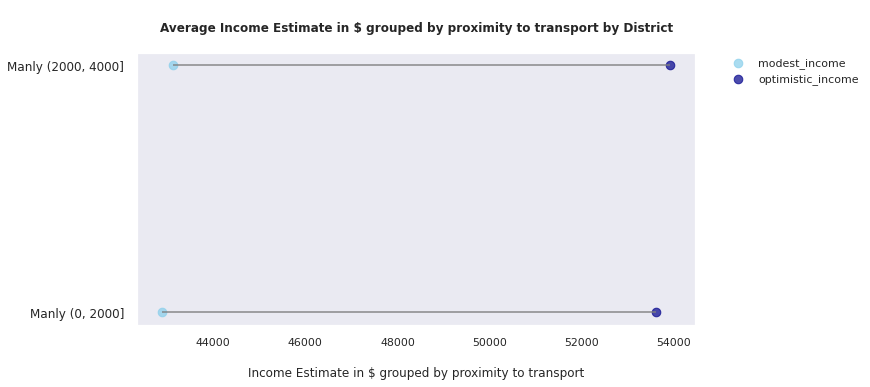

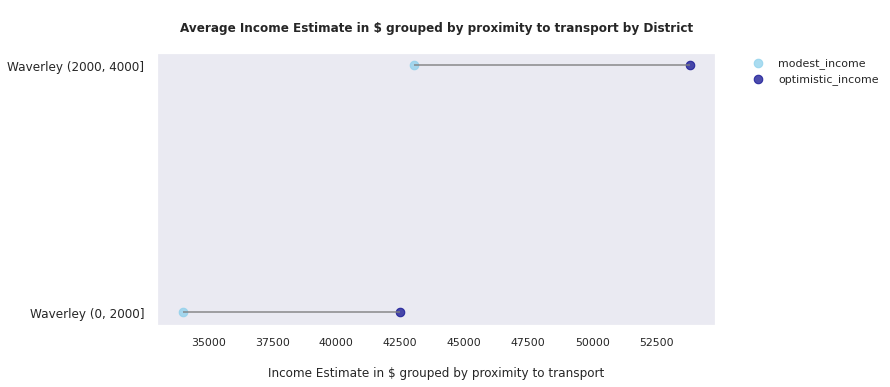

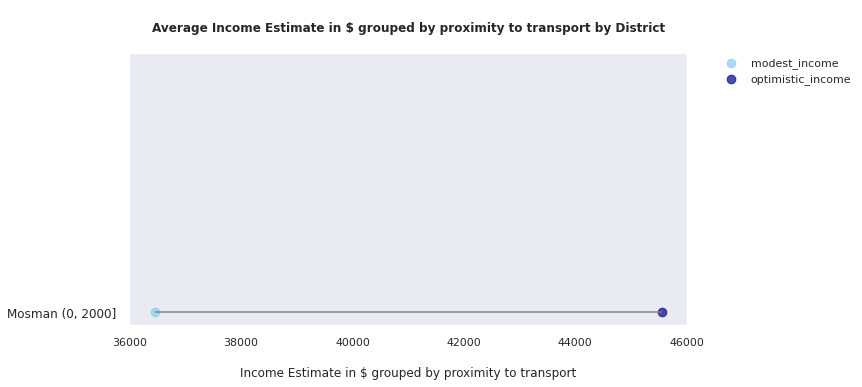

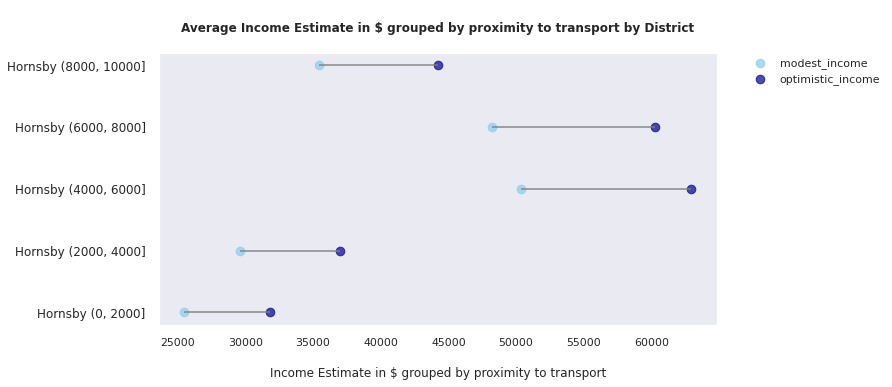

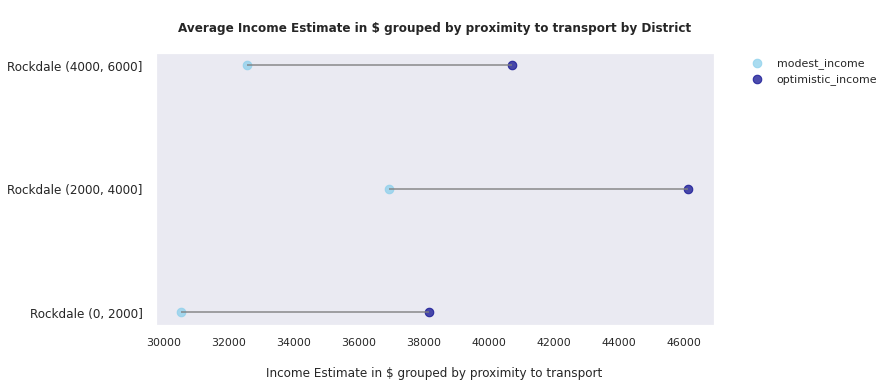

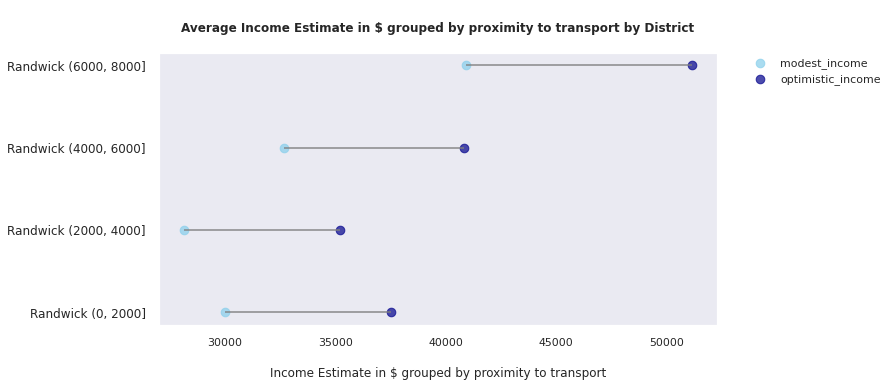

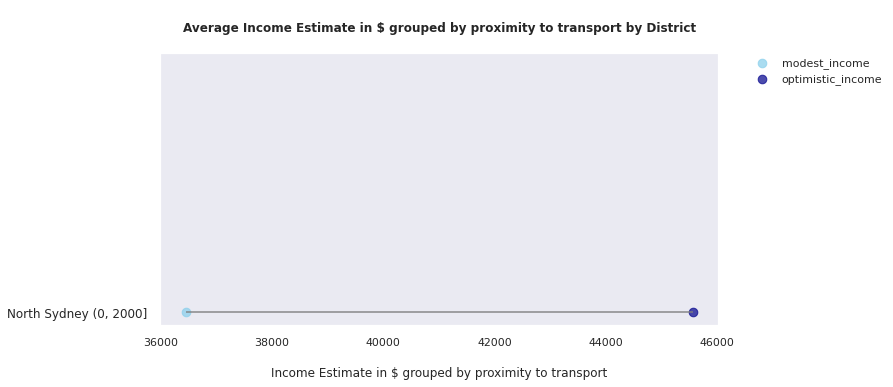

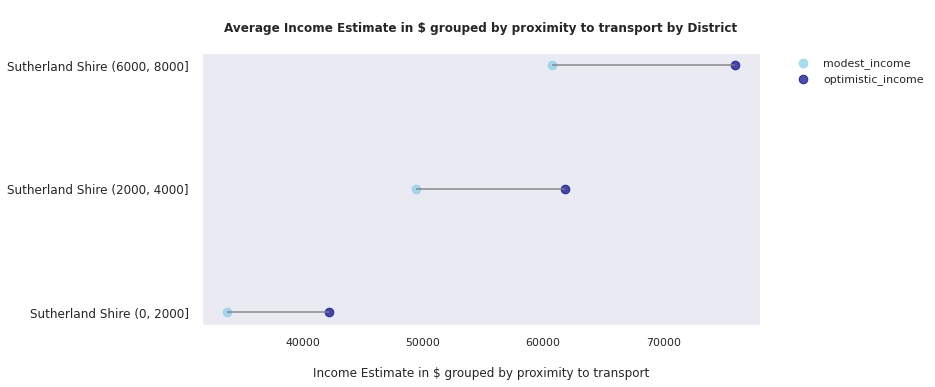

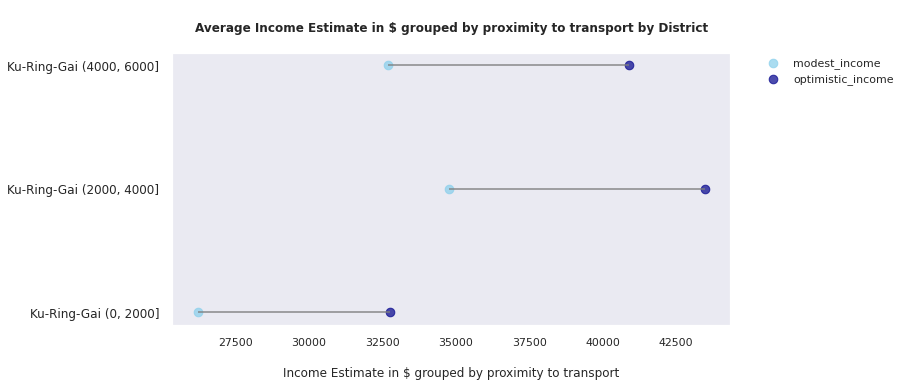

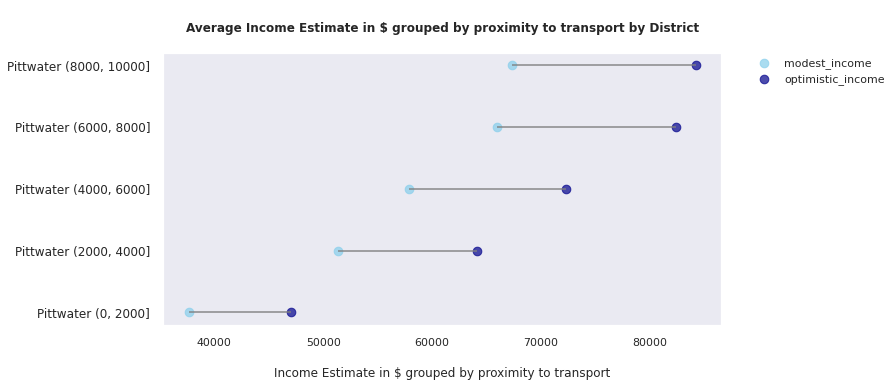

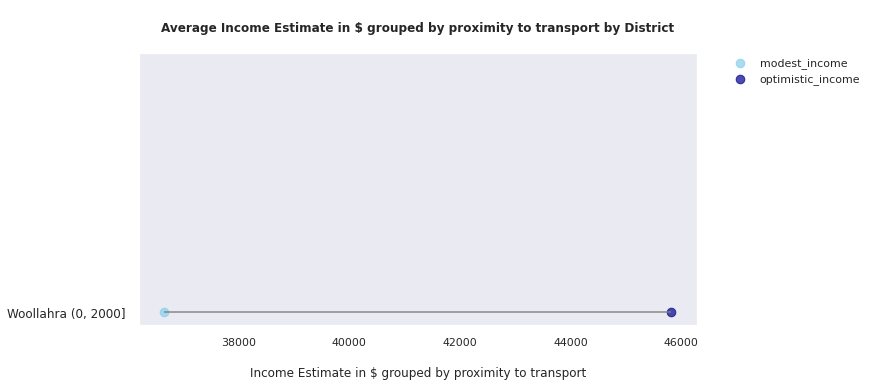

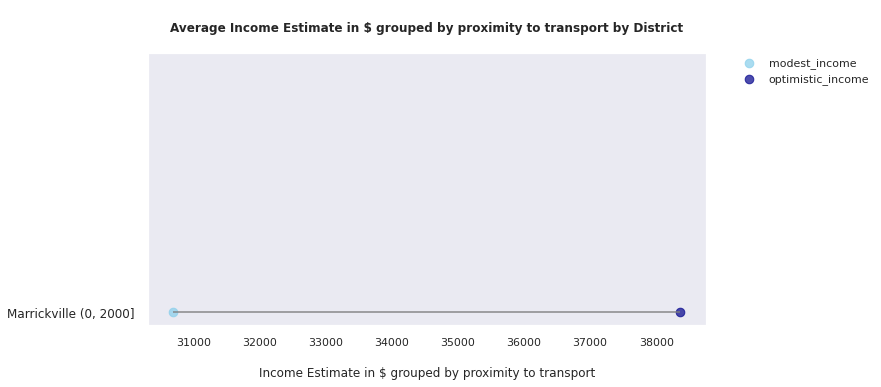

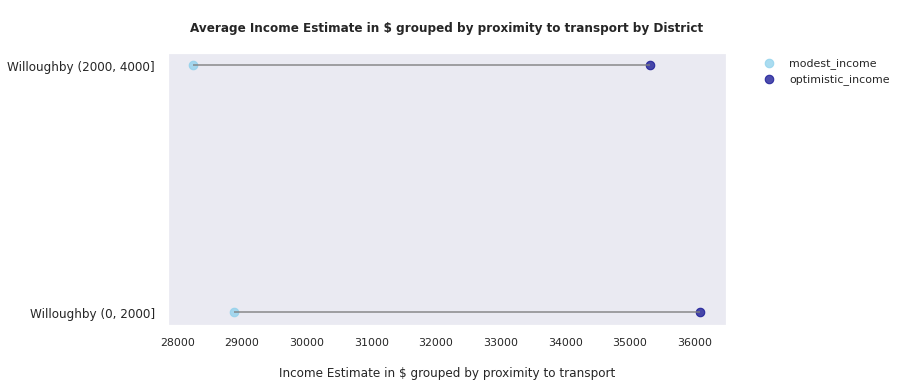

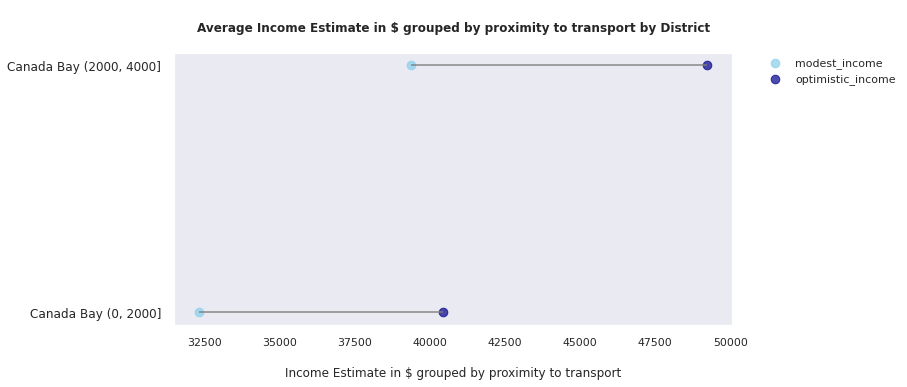

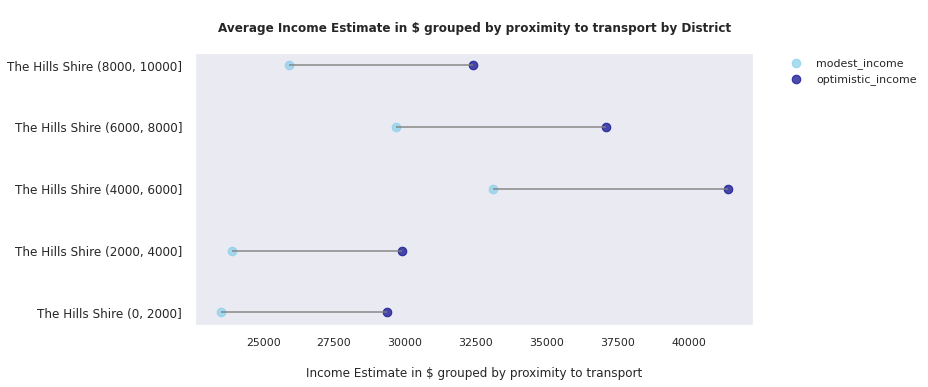

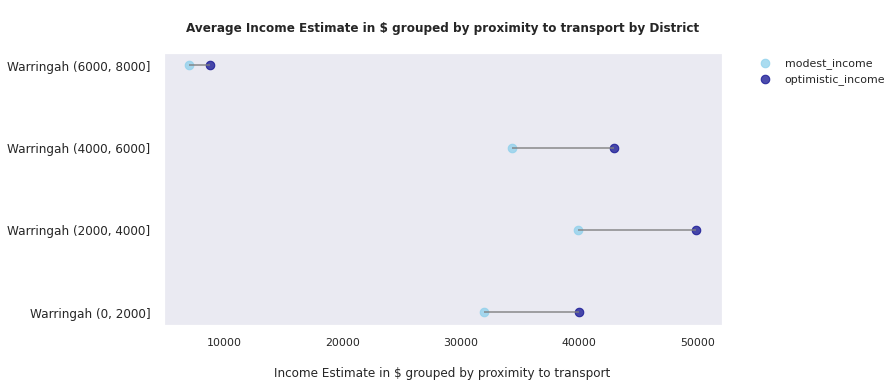

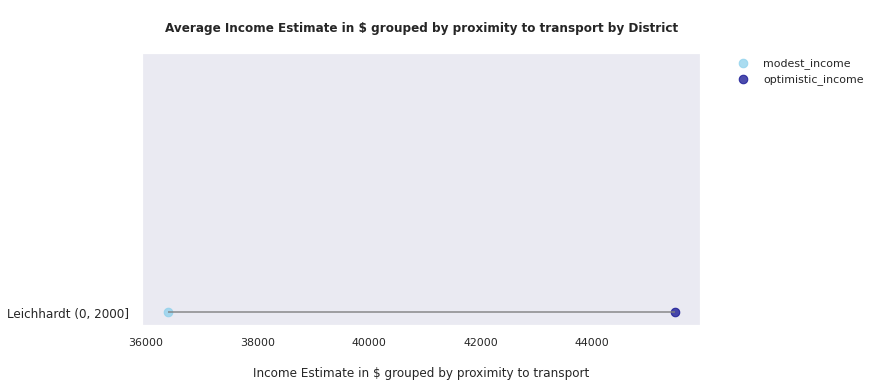

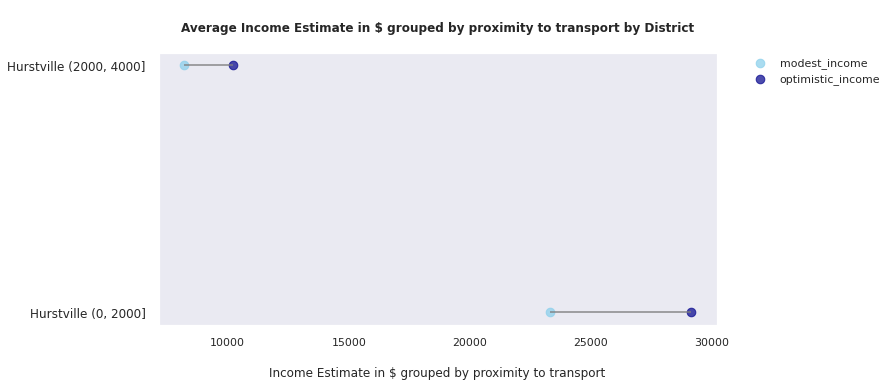

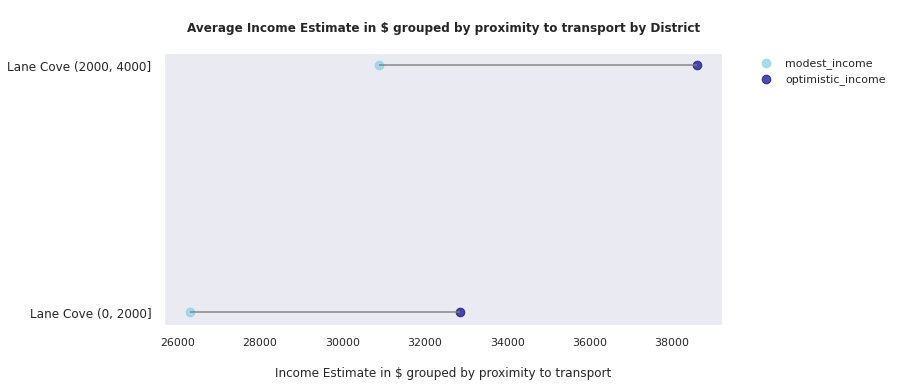

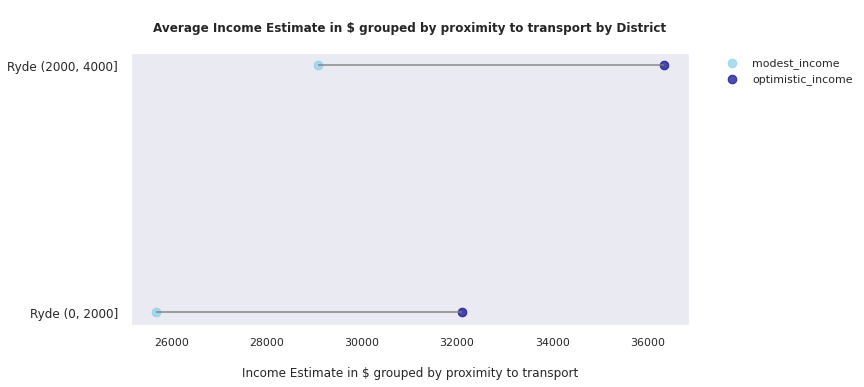

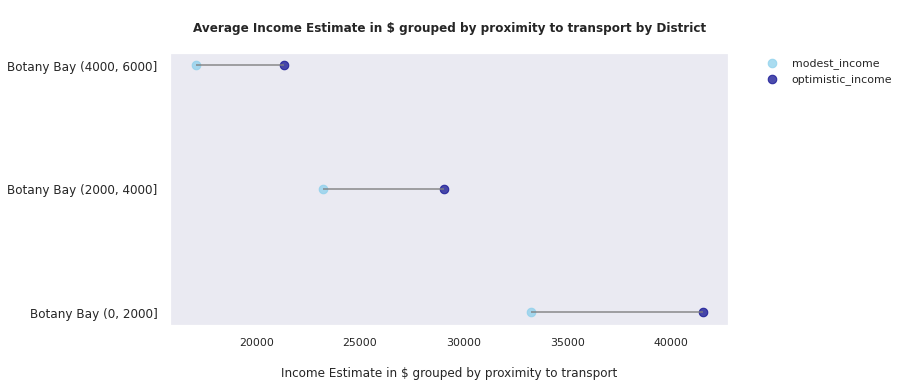

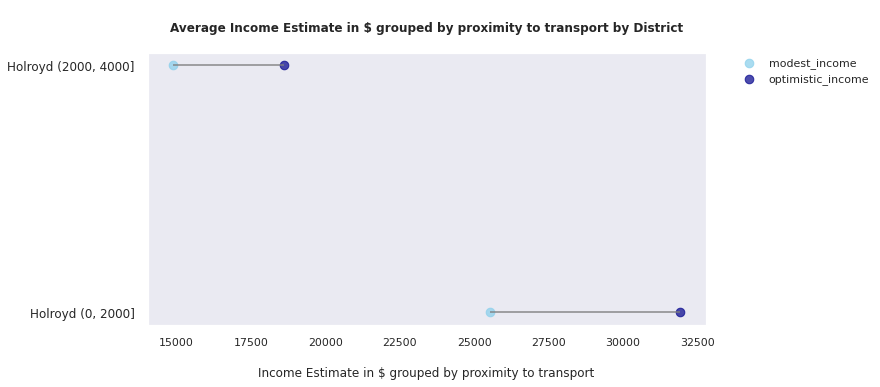

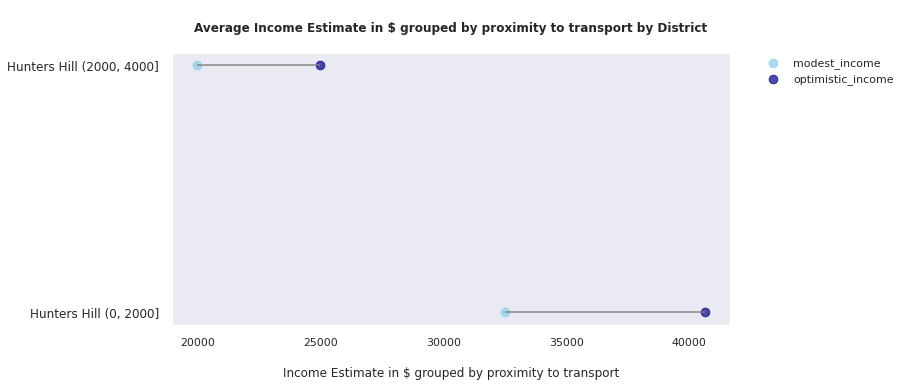

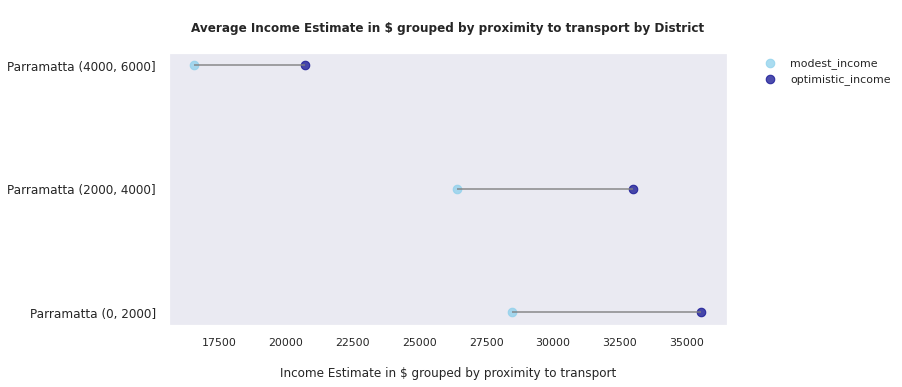

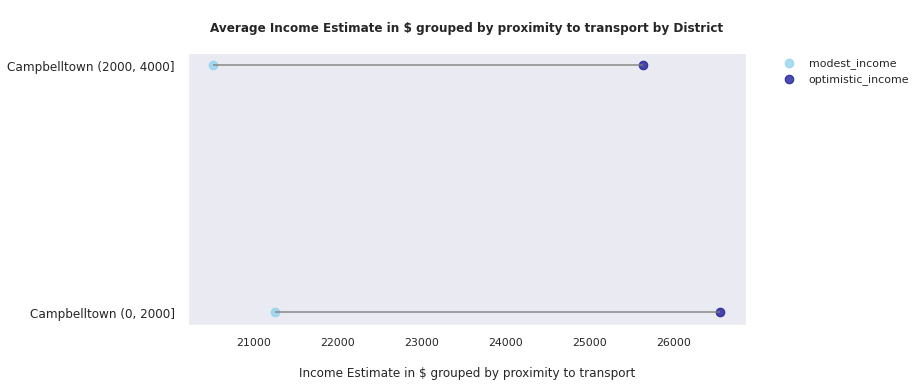

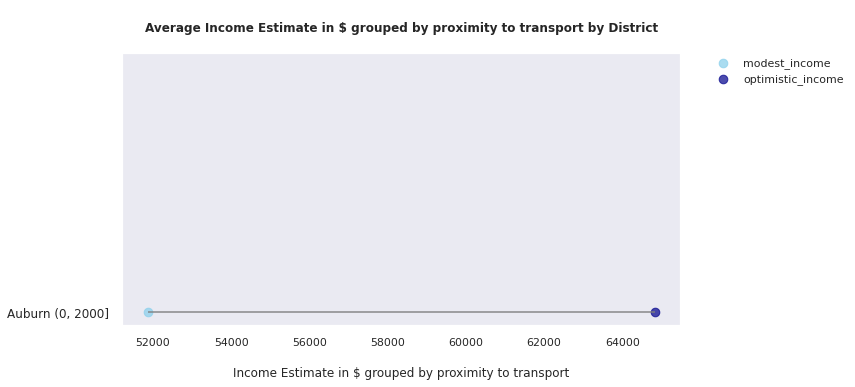

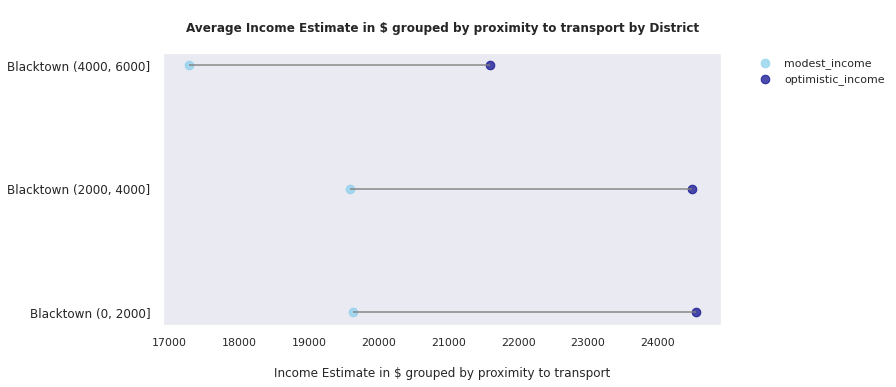

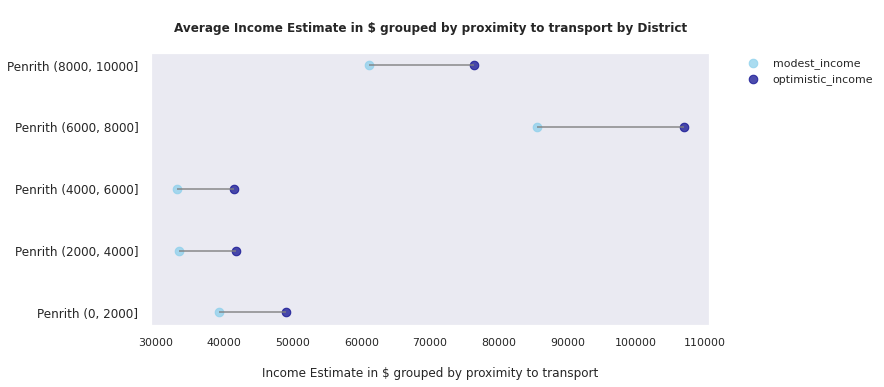

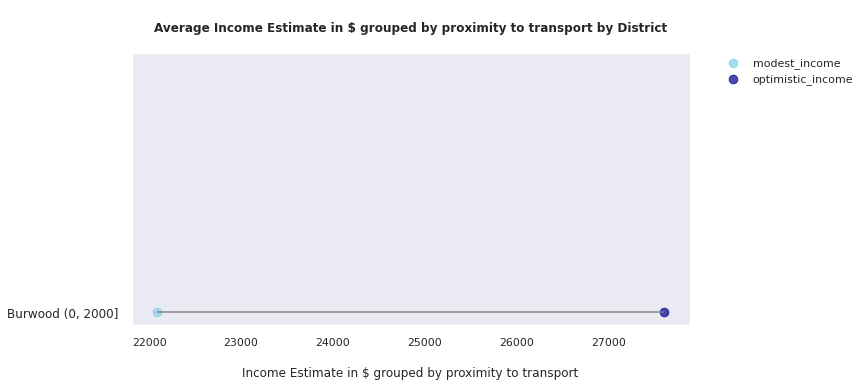

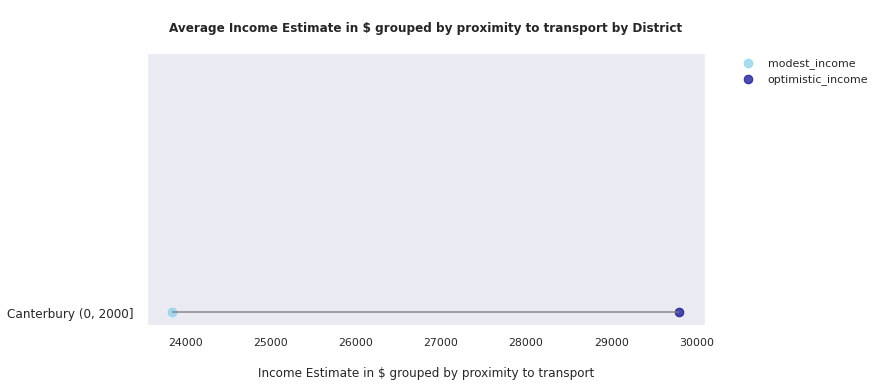

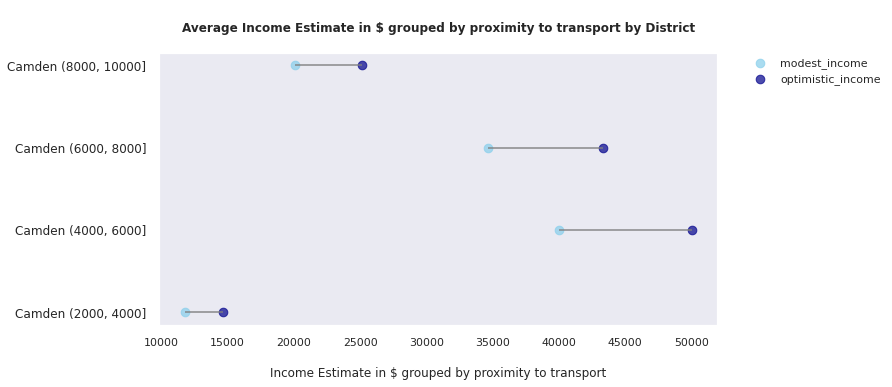

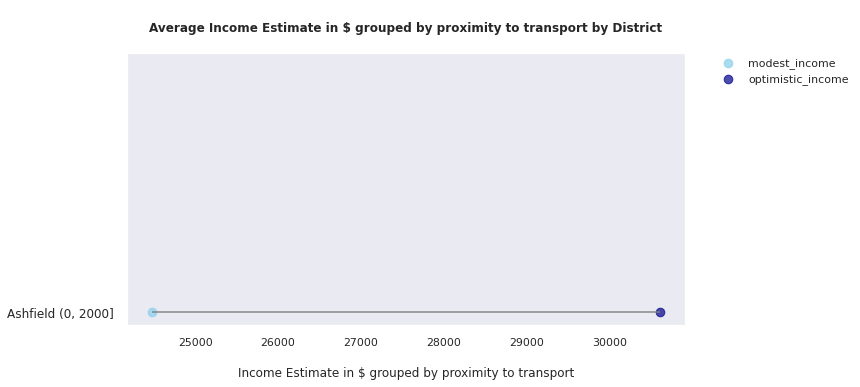

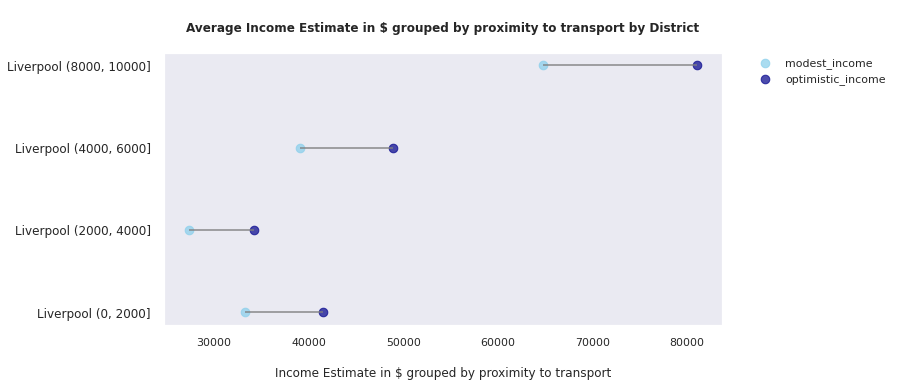

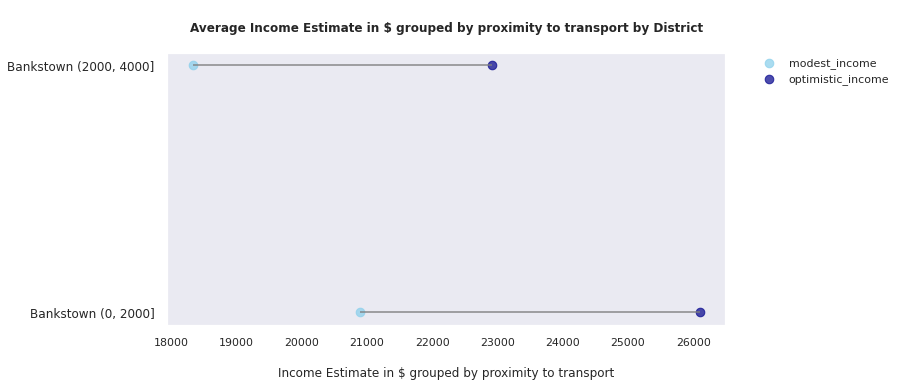

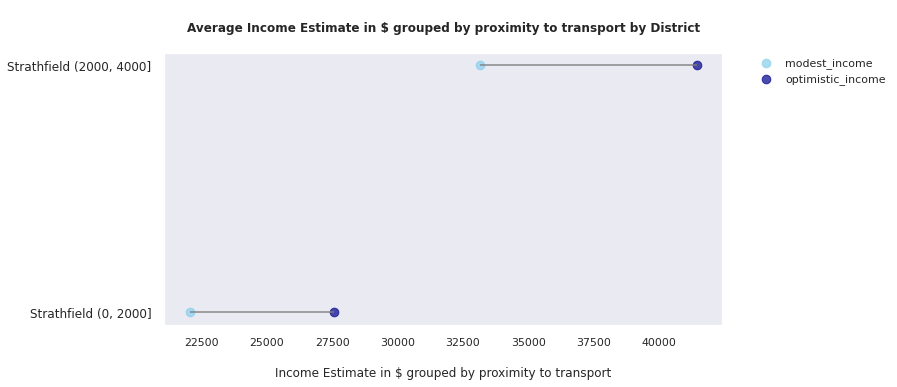

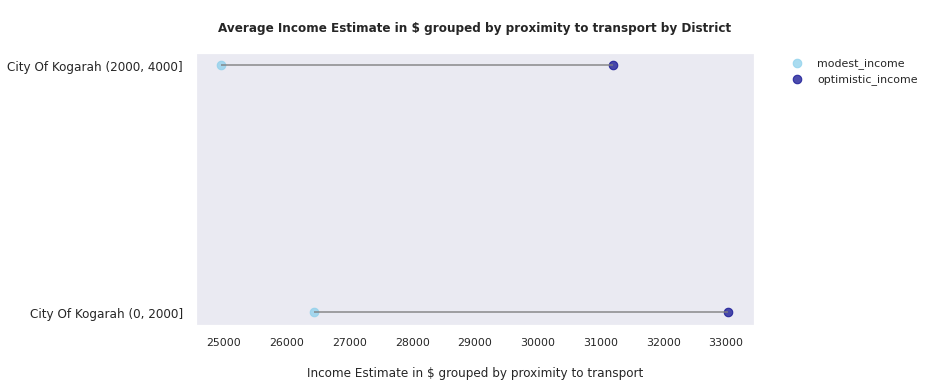

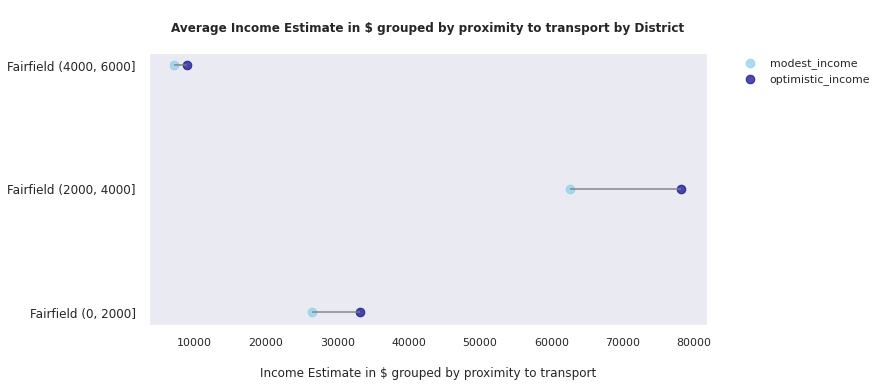

In [78]:
for district in list(df.neighbourhood.unique()):
    lollipop_with_proximity(df, 
                            'Income Estimate in $ grouped by proximity to transport', 
                            'neighbourhood', 
                            'modest_income', 
                            'optimistic_income',
                            [district],
                            discrete_bins=True
                           )

## Conclusion

### Seasonality

The seasonal demand for AirBnB listings in Sydney is quite visible. The high season for lodgings in Sydney is during early in the year during Autumn (March), and then later in the year again during Spring (November). It would be judicious to use an apartment during the rest of the year and offer it as a listing during March and November to get the best value out of the apartment.

### Super Host status

To be a super host is to generate a lot of income and have a high occupancy rate. In some neighbourhhods, the income and occupancy rates of super hosts are 60% higher than those of normal hosts!  

### Location

Location is an interesting aspect in Sydney for AirBnB listings. While it may seem from occupancy rates that regions like Fairfield and Rockdale are doing fairly well, it becomes more clear that regions near attraction spots such as beaches, e.g. Pittwater, Manly and Sutherly Shire are doing better income-wise. However, it is interesting to note that areas such as Sydney CBD and Auburn both have very high occupancy rates and income, which makes sense for Sydney CBD - being the heart of Sydney, but quite surprising for Auburn.

### Proximity to Transport services

While proximity to transport services usually affect rent prices across Sydney neighbourhoods, the trend doesn't seem to hold too strong for AirBnB listings. However, there are certain patterns that are predictable. For example, incomes from listings closer to transport services in city areas such as Sydney CBD, Hurstville, Paramatta and Campbelltown generate more income. 
However, for listings located near attraction spots, the trend appears to be the opposite. This might be because the listings are generally closer to the attraction spots and farther away from train stations and bus stops - which makes their income go up the farther they are away from the transport services, but the closer they are to the attraction spots.

### Capacity

It is also quite noticeable from the correlation heat map, that factor such as capacity (`accomodates`), the number of bedrooms and bathrooms are also highly correlated with income. This means that listings which have a higher capacity generally tend to generate more income. 